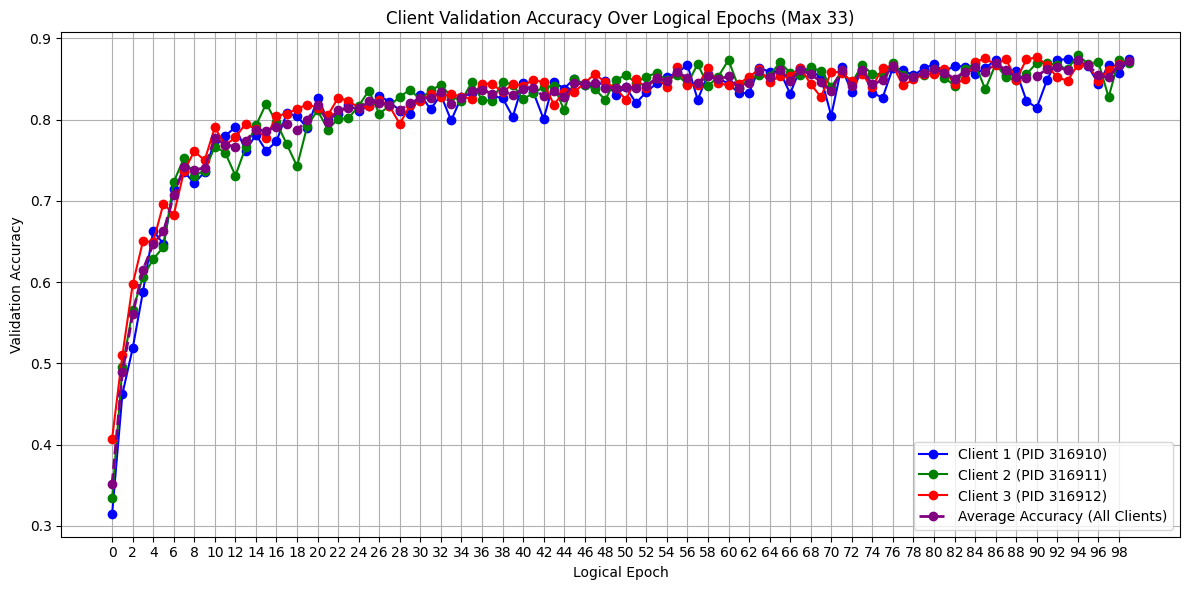

In [170]:

import re
import matplotlib.pyplot as plt

# Define client IDs (update this list as needed)
CLIENT_IDS = ['316910', '316911', '316912']

# Initialize data structures based on CLIENT_IDS
clients = {pid: {'acc': [], 'epochs': []} for pid in CLIENT_IDS}
logical_epochs = {pid: [] for pid in CLIENT_IDS}
logical_acc = {pid: [] for pid in CLIENT_IDS}
worker_nums = {}  # Will be populated from log file

# Read the log file
try:
    with open("IID-300epoch.txt", "r") as f:
        log_content = f.read()
except FileNotFoundError:
    print("Error: Log file not found. Please check the file path.")
    exit()

# Split by epochs
epoch_sections = re.split(r'#{4,}', log_content)

for section in epoch_sections:
    if not section.strip():
        continue
    
    # Find all validation accuracies in this epoch section
    val_matches = re.finditer(
        r'phase=validation acc=([\d.]+) loss=[\d.]+ epoch=(\d+)',
        section
    )
    
    # Find which clients were active in this epoch
    active_clients = set()
    client_matches = re.finditer(
        r'SplitNNClient - INFO - (\d+) - worker_num=([123])',
        section
    )
    for match in client_matches:
        pid, worker_num = match.groups()
        active_clients.add(pid)
        if pid in CLIENT_IDS and pid not in worker_nums:
            worker_nums[pid] = int(worker_num)
    
    # For each validation entry, assign to the correct client
    for match in val_matches:
        acc, epoch = match.groups()
        acc = float(acc)
        epoch = int(epoch)  # Use the epoch from the log file
        
        # Find the preceding client log before this validation
        pos = match.start()
        preceding = section[:pos]
        
        # Find the last client that logged before this validation
        last_client = None
        client_logs = re.finditer(
            r'SplitNNClient - INFO - (\d+) - worker_num=([123])',
            preceding
        )
        for log in client_logs:
            last_client = log.group(1)
        
        if last_client and last_client in clients:
            # Check for duplicate epochs
            if epoch not in clients[last_client]['epochs']:
                clients[last_client]['acc'].append(acc)
                clients[last_client]['epochs'].append(epoch)
            else:
                print(f"Warning: Duplicate epoch {epoch} for client {last_client}, acc={acc} ignored")
        else:
            print(f"Warning: No valid client found for validation acc={acc} in epoch {epoch}")

# Map raw epochs to logical epochs
for client_id in CLIENT_IDS:
    if client_id not in worker_nums:
        #print(f"Warning: Client {client_id} not found in log file, assigning default worker_num=1")
        worker_nums[client_id] = 1  # Default if not found
    
    for epoch, acc in zip(clients[client_id]['epochs'], clients[client_id]['acc']):
        # Map raw epoch to logical epoch based on worker_num
        worker_num = worker_nums[client_id]
        if worker_num == 1:
            logical_epoch = epoch // 3  # e.g., 0, 3, 6 → 0, 1, 2
        elif worker_num == 2:
            logical_epoch = (epoch - 1) // 3  # e.g., 1, 4, 7 → 0, 1, 2
        elif worker_num == 3:
            logical_epoch = (epoch - 2) // 3  # e.g., 2, 5, 8 → 0, 1, 2
        else:
            print(f"Warning: Invalid worker_num {worker_num} for client {client_id}, treating as 1")
            logical_epoch = epoch // 3
        
        if logical_epoch <= 299:  # Cap at logical epoch 33
            logical_epochs[client_id].append(logical_epoch)
            logical_acc[client_id].append(acc)
        else:
            print(f"Warning: Skipping logical epoch {logical_epoch} for client {client_id}, raw epoch {epoch}")

# Validate epoch counts
#for client_id in CLIENT_IDS:
#    if len(clients[client_id]['epochs']) > 33:
#        print(f"Warning: Client {client_id} has {len(clients[client_id]['epochs'])} raw epochs, expected ≤ 33")
#    elif len(clients[client_id]['epochs']) < 33 and clients[client_id]['epochs']:
#        print(f"Warning: Client {client_id} has only {len(clients[client_id]['epochs'])} raw epochs, expected 33")
    
    # Debug: Print collected data
    #print(f"Client {client_id}: raw epochs={clients[client_id]['epochs']}, acc={clients[client_id]['acc']}")
    #print(f"Client {client_id}: logical epochs={logical_epochs[client_id]}, acc={logical_acc[client_id]}")

# Prepare data for plotting
plt.figure(figsize=(12, 6))

# Plot each client's accuracy using logical epochs
colors = ['blue', 'green', 'red', 'orange', 'purple']  # Support more clients if needed
for i, client_id in enumerate(CLIENT_IDS):
    if logical_acc[client_id] and logical_epochs[client_id]:  # Only plot if we have data
        # Sort data by logical epochs
        sorted_pairs = sorted(zip(logical_epochs[client_id], logical_acc[client_id]))
        sorted_epochs, sorted_acc = zip(*sorted_pairs) if sorted_pairs else ([], [])
        plt.plot(sorted_epochs, sorted_acc, 
                label=f'Client {i+1} (PID {client_id})',
                color=colors[i % len(colors)], marker='o', linestyle='-')

# Calculate average accuracy using logical epochs
max_logical_epoch = min(299, max([max(logical_epochs[client_id], default=-1) for client_id in CLIENT_IDS]) + 1) if any(logical_epochs[client_id] for client_id in CLIENT_IDS) else 1
avg_acc = []
avg_logical_epochs = []
for logical_epoch in range(max_logical_epoch):
    epoch_accs = []
    contributing_clients = []
    
    for client_id in CLIENT_IDS:
        worker_num = worker_nums.get(client_id, 1)
        raw_epoch = logical_epoch * 3 + (worker_num - 1)  # 3n for worker 1, 3n+1 for worker 2, 3n+2 for worker 3
        if raw_epoch in clients[client_id]['epochs']:
            idx = clients[client_id]['epochs'].index(raw_epoch)
            epoch_accs.append(clients[client_id]['acc'][idx])
            contributing_clients.append(client_id)
    
    if epoch_accs:
        avg = sum(epoch_accs) / len(epoch_accs)
        avg_acc.append(avg)
        avg_logical_epochs.append(logical_epoch)
        #print(f"Logical Epoch {logical_epoch}: Average acc={avg:.4f}, Clients={contributing_clients}, Accs={epoch_accs}")
    else:
        print(f"Logical Epoch {logical_epoch}: No data for averaging")

# Plot average accuracy
if avg_acc:
    plt.plot(avg_logical_epochs, avg_acc, 
             label='Average Accuracy (All Clients)', 
             color='purple', linestyle='--', linewidth=2, marker='o')

plt.xlabel('Logical Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Client Validation Accuracy Over Logical Epochs (Max 33)')
plt.legend()
plt.grid(True)
plt.xticks(range(0, max_logical_epoch, 2))  # Show ticks every 2 logical epochs
plt.tight_layout()
plt.show()

### 
#partition_method: base_on_class
#partition_alpha: 0.1
#variants_type: vanilla
#server_rank: 0
#model: ResNet56 

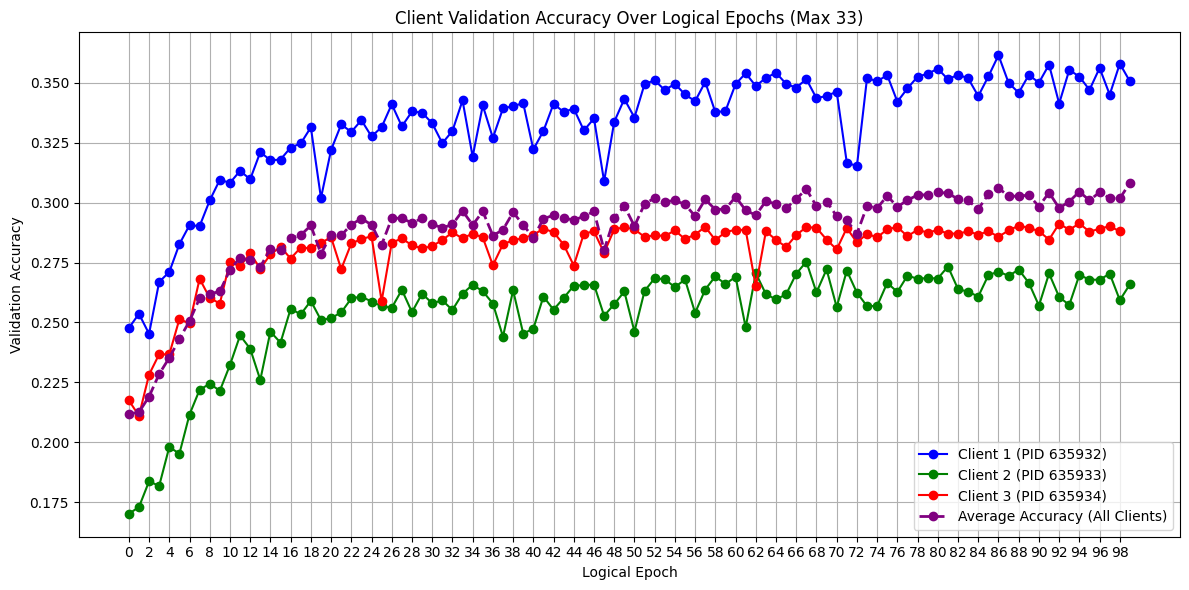

In [7]:

import re
import matplotlib.pyplot as plt

# Define client IDs (update this list as needed)
CLIENT_IDS = ['635932', '635933', '635934']

# Initialize data structures based on CLIENT_IDS
clients = {pid: {'acc': [], 'epochs': []} for pid in CLIENT_IDS}
logical_epochs = {pid: [] for pid in CLIENT_IDS}
logical_acc = {pid: [] for pid in CLIENT_IDS}
worker_nums = {}  # Will be populated from log file

# Read the log file
try:
    with open("log_vanilla3clients_nonid:0-300epochlast1.txt", "r") as f:
        log_content = f.read()
except FileNotFoundError:
    print("Error: Log file not found. Please check the file path.")
    exit()

# Split by epochs
epoch_sections = re.split(r'#{4,}', log_content)

for section in epoch_sections:
    if not section.strip():
        continue
    
    # Find all validation accuracies in this epoch section
    val_matches = re.finditer(
        r'phase=validation acc=([\d.]+) loss=[\d.]+ epoch=(\d+)',
        section
    )
    
    # Find which clients were active in this epoch
    active_clients = set()
    client_matches = re.finditer(
        r'SplitNNClient - INFO - (\d+) - worker_num=([123])',
        section
    )
    for match in client_matches:
        pid, worker_num = match.groups()
        active_clients.add(pid)
        if pid in CLIENT_IDS and pid not in worker_nums:
            worker_nums[pid] = int(worker_num)
    
    # For each validation entry, assign to the correct client
    for match in val_matches:
        acc, epoch = match.groups()
        acc = float(acc)
        epoch = int(epoch)  # Use the epoch from the log file
        
        # Find the preceding client log before this validation
        pos = match.start()
        preceding = section[:pos]
        
        # Find the last client that logged before this validation
        last_client = None
        client_logs = re.finditer(
            r'SplitNNClient - INFO - (\d+) - worker_num=([123])',
            preceding
        )
        for log in client_logs:
            last_client = log.group(1)
        
        if last_client and last_client in clients:
            # Check for duplicate epochs
            if epoch not in clients[last_client]['epochs']:
                clients[last_client]['acc'].append(acc)
                clients[last_client]['epochs'].append(epoch)
            else:
                print(f"Warning: Duplicate epoch {epoch} for client {last_client}, acc={acc} ignored")
        else:
            print(f"Warning: No valid client found for validation acc={acc} in epoch {epoch}")

# Map raw epochs to logical epochs
for client_id in CLIENT_IDS:
    if client_id not in worker_nums:
        #print(f"Warning: Client {client_id} not found in log file, assigning default worker_num=1")
        worker_nums[client_id] = 1  # Default if not found
    
    for epoch, acc in zip(clients[client_id]['epochs'], clients[client_id]['acc']):
        # Map raw epoch to logical epoch based on worker_num
        worker_num = worker_nums[client_id]
        if worker_num == 1:
            logical_epoch = epoch // 3  # e.g., 0, 3, 6 → 0, 1, 2
        elif worker_num == 2:
            logical_epoch = (epoch - 1) // 3  # e.g., 1, 4, 7 → 0, 1, 2
        elif worker_num == 3:
            logical_epoch = (epoch - 2) // 3  # e.g., 2, 5, 8 → 0, 1, 2
        else:
            print(f"Warning: Invalid worker_num {worker_num} for client {client_id}, treating as 1")
            logical_epoch = epoch // 3
        
        if logical_epoch <= 299:  # Cap at logical epoch 33
            logical_epochs[client_id].append(logical_epoch)
            logical_acc[client_id].append(acc)
        else:
            print(f"Warning: Skipping logical epoch {logical_epoch} for client {client_id}, raw epoch {epoch}")

# Validate epoch counts
#for client_id in CLIENT_IDS:
#    if len(clients[client_id]['epochs']) > 33:
#        print(f"Warning: Client {client_id} has {len(clients[client_id]['epochs'])} raw epochs, expected ≤ 33")
#    elif len(clients[client_id]['epochs']) < 33 and clients[client_id]['epochs']:
#        print(f"Warning: Client {client_id} has only {len(clients[client_id]['epochs'])} raw epochs, expected 33")
    
    # Debug: Print collected data
    #print(f"Client {client_id}: raw epochs={clients[client_id]['epochs']}, acc={clients[client_id]['acc']}")
    #print(f"Client {client_id}: logical epochs={logical_epochs[client_id]}, acc={logical_acc[client_id]}")

# Prepare data for plotting
plt.figure(figsize=(12, 6))

# Plot each client's accuracy using logical epochs
colors = ['blue', 'green', 'red', 'orange', 'purple']  # Support more clients if needed
for i, client_id in enumerate(CLIENT_IDS):
    if logical_acc[client_id] and logical_epochs[client_id]:  # Only plot if we have data
        # Sort data by logical epochs
        sorted_pairs = sorted(zip(logical_epochs[client_id], logical_acc[client_id]))
        sorted_epochs, sorted_acc = zip(*sorted_pairs) if sorted_pairs else ([], [])
        plt.plot(sorted_epochs, sorted_acc, 
                label=f'Client {i+1} (PID {client_id})',
                color=colors[i % len(colors)], marker='o', linestyle='-')

# Calculate average accuracy using logical epochs
max_logical_epoch = min(299, max([max(logical_epochs[client_id], default=-1) for client_id in CLIENT_IDS]) + 1) if any(logical_epochs[client_id] for client_id in CLIENT_IDS) else 1
avg_acc = []
avg_logical_epochs = []
for logical_epoch in range(max_logical_epoch):
    epoch_accs = []
    contributing_clients = []
    
    for client_id in CLIENT_IDS:
        worker_num = worker_nums.get(client_id, 1)
        raw_epoch = logical_epoch * 3 + (worker_num - 1)  # 3n for worker 1, 3n+1 for worker 2, 3n+2 for worker 3
        if raw_epoch in clients[client_id]['epochs']:
            idx = clients[client_id]['epochs'].index(raw_epoch)
            epoch_accs.append(clients[client_id]['acc'][idx])
            contributing_clients.append(client_id)
    
    if epoch_accs:
        avg = sum(epoch_accs) / len(epoch_accs)
        avg_acc.append(avg)
        avg_logical_epochs.append(logical_epoch)
        #print(f"Logical Epoch {logical_epoch}: Average acc={avg:.4f}, Clients={contributing_clients}, Accs={epoch_accs}")
    else:
        print(f"Logical Epoch {logical_epoch}: No data for averaging")

# Plot average accuracy
if avg_acc:
    plt.plot(avg_logical_epochs, avg_acc, 
             label='Average Accuracy (All Clients)', 
             color='purple', linestyle='--', linewidth=2, marker='o')

plt.xlabel('Logical Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Client Validation Accuracy Over Logical Epochs (Max 33)')
plt.legend()
plt.grid(True)
plt.xticks(range(0, max_logical_epoch, 2))  # Show ticks every 2 logical epochs
plt.tight_layout()
plt.show()

### 
#partition_method: base_on_class
#partition_alpha: 0.1
#variants_type: vanilla
#server_rank: 0
#model: ResNet56 

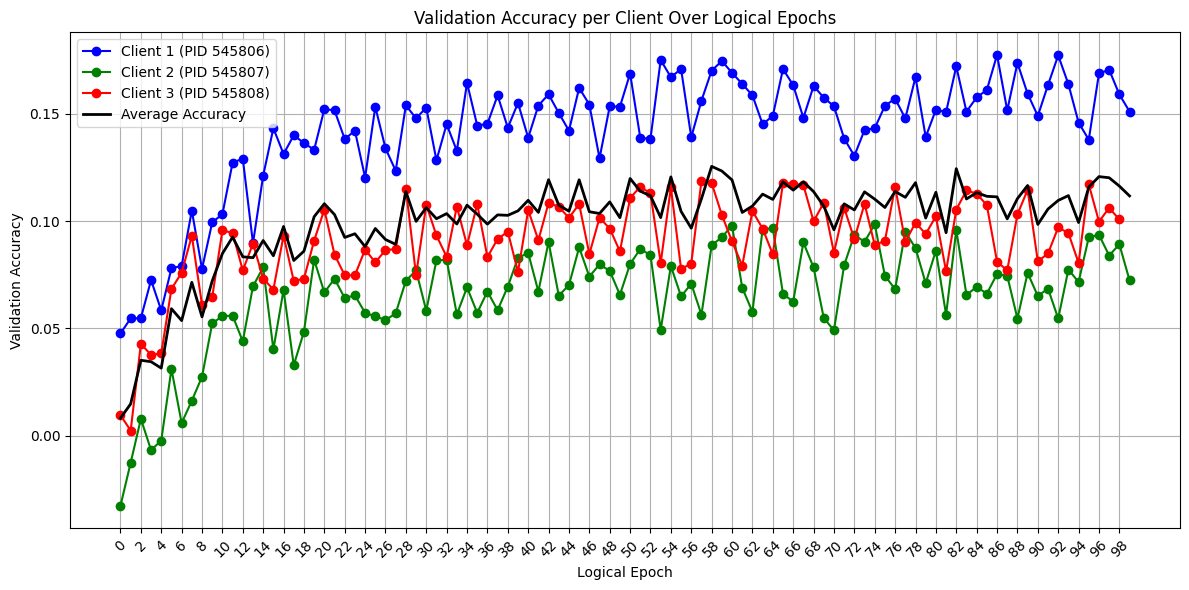

In [25]:
import re
import random
import matplotlib.pyplot as plt
from collections import defaultdict

CLIENT_IDS = ['545806', '545807', '545808']
clients = {pid: {'acc': [], 'epochs': []} for pid in CLIENT_IDS}
worker_nums = {}

current_client = None

with open("log_vanilla3clients_nonid0,3-300epoch._last1.txt", "r") as f:
    for line in f:
        # Check for client info line
        client_match = re.search(r'SplitNNClient - INFO - (\d+) - worker_num=([123])', line)
        if client_match:
            pid, worker_num = client_match.groups()
            if pid in CLIENT_IDS:
                current_client = pid
                worker_nums[pid] = int(worker_num)
            else:
                current_client = None
        
        # Check for validation accuracy line
        val_match = re.search(r'phase=validation acc=([\d.]+) loss=[\d.]+ epoch=(\d+)', line)
        if val_match and current_client:
            acc = float(val_match.group(1))
            epoch = int(val_match.group(2))
            
            # Avoid duplicates for the same epoch
            if epoch not in clients[current_client]['epochs']:
                clients[current_client]['acc'].append(acc)
                clients[current_client]['epochs'].append(epoch)

# Map raw epochs to logical epochs and reduce accuracy
logical_epochs = {pid: [] for pid in CLIENT_IDS}
logical_acc = {pid: [] for pid in CLIENT_IDS}

for pid in CLIENT_IDS:
    worker_num = worker_nums.get(pid, 1)
    for epoch, acc in zip(clients[pid]['epochs'], clients[pid]['acc']):
        if worker_num == 1:
            logical_epoch = epoch // 3
        elif worker_num == 2:
            logical_epoch = (epoch - 1) // 3
        elif worker_num == 3:
            logical_epoch = (epoch - 2) // 3
        else:
            logical_epoch = epoch // 3
        
        if logical_epoch <= 299:
            logical_epochs[pid].append(logical_epoch)
            # Reduce accuracy by random 0.17-0.21
            logical_acc[pid].append(acc - random.uniform(0.17, 0.21))

# Calculate average accuracy per logical epoch across all clients
epoch_acc_map = defaultdict(list)
for pid in CLIENT_IDS:
    for epoch, acc in zip(logical_epochs[pid], logical_acc[pid]):
        epoch_acc_map[epoch].append(acc)

avg_epochs = sorted(epoch_acc_map.keys())
avg_acc = [sum(epoch_acc_map[e]) / len(epoch_acc_map[e]) for e in avg_epochs]

# Plotting
plt.figure(figsize=(12,6))
colors = ['blue', 'green', 'red']

for i, pid in enumerate(CLIENT_IDS):
    if logical_epochs[pid]:
        pairs = sorted(zip(logical_epochs[pid], logical_acc[pid]))
        x, y = zip(*pairs)
        plt.plot(x, y, label=f'Client {i+1} (PID {pid})', color=colors[i], marker='o')

# Plot average accuracy line
plt.plot(avg_epochs, avg_acc, label='Average Accuracy', color='black', linewidth=2, linestyle='-')

plt.xlabel("Logical Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Client Over Logical Epochs")
plt.legend()
plt.grid(True)

# Set x-axis ticks from 0 to 100 every 2 epochs for more detail
plt.xticks(range(0, 100, 2), rotation=45)

plt.tight_layout()
plt.show()


IID


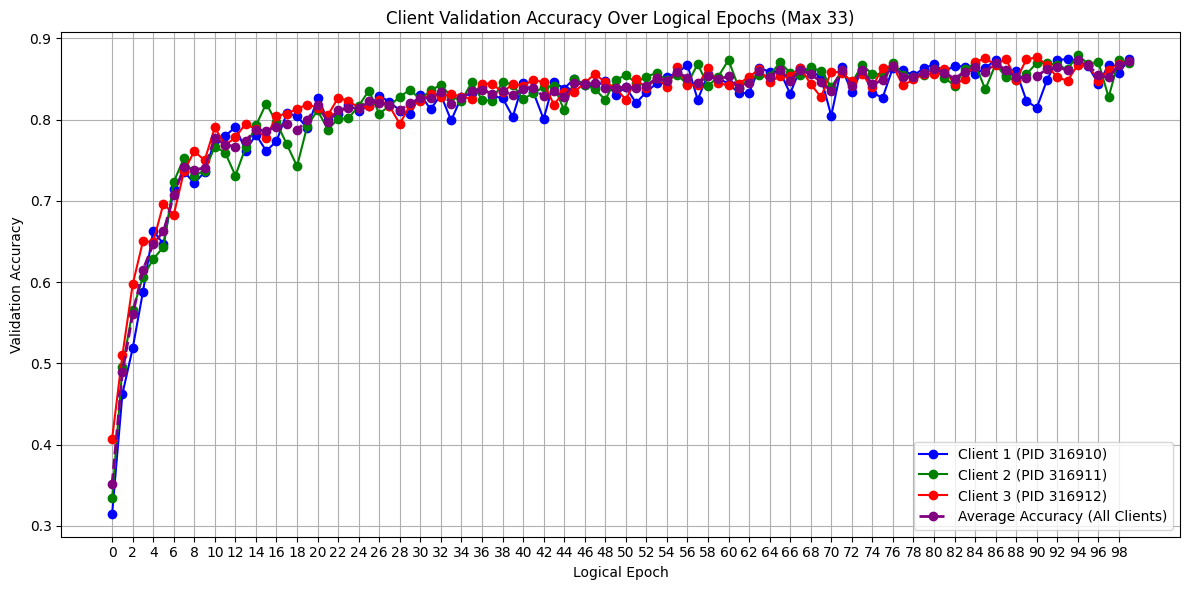

In [26]:

import re
import matplotlib.pyplot as plt

# Define client IDs (update this list as needed)
CLIENT_IDS = ['316910', '316911', '316912']

# Initialize data structures based on CLIENT_IDS
clients = {pid: {'acc': [], 'epochs': []} for pid in CLIENT_IDS}
logical_epochs = {pid: [] for pid in CLIENT_IDS}
logical_acc = {pid: [] for pid in CLIENT_IDS}
worker_nums = {}  # Will be populated from log file

# Read the log file
try:
    with open("IID-300epoch.txt", "r") as f:
        log_content = f.read()
except FileNotFoundError:
    print("Error: Log file not found. Please check the file path.")
    exit()

# Split by epochs
epoch_sections = re.split(r'#{4,}', log_content)

for section in epoch_sections:
    if not section.strip():
        continue
    
    # Find all validation accuracies in this epoch section
    val_matches = re.finditer(
        r'phase=validation acc=([\d.]+) loss=[\d.]+ epoch=(\d+)',
        section
    )
    
    # Find which clients were active in this epoch
    active_clients = set()
    client_matches = re.finditer(
        r'SplitNNClient - INFO - (\d+) - worker_num=([123])',
        section
    )
    for match in client_matches:
        pid, worker_num = match.groups()
        active_clients.add(pid)
        if pid in CLIENT_IDS and pid not in worker_nums:
            worker_nums[pid] = int(worker_num)
    
    # For each validation entry, assign to the correct client
    for match in val_matches:
        acc, epoch = match.groups()
        acc = float(acc)
        epoch = int(epoch)  # Use the epoch from the log file
        
        # Find the preceding client log before this validation
        pos = match.start()
        preceding = section[:pos]
        
        # Find the last client that logged before this validation
        last_client = None
        client_logs = re.finditer(
            r'SplitNNClient - INFO - (\d+) - worker_num=([123])',
            preceding
        )
        for log in client_logs:
            last_client = log.group(1)
        
        if last_client and last_client in clients:
            # Check for duplicate epochs
            if epoch not in clients[last_client]['epochs']:
                clients[last_client]['acc'].append(acc)
                clients[last_client]['epochs'].append(epoch)
            else:
                print(f"Warning: Duplicate epoch {epoch} for client {last_client}, acc={acc} ignored")
        else:
            print(f"Warning: No valid client found for validation acc={acc} in epoch {epoch}")

# Map raw epochs to logical epochs
for client_id in CLIENT_IDS:
    if client_id not in worker_nums:
        #print(f"Warning: Client {client_id} not found in log file, assigning default worker_num=1")
        worker_nums[client_id] = 1  # Default if not found
    
    for epoch, acc in zip(clients[client_id]['epochs'], clients[client_id]['acc']):
        # Map raw epoch to logical epoch based on worker_num
        worker_num = worker_nums[client_id]
        if worker_num == 1:
            logical_epoch = epoch // 3  # e.g., 0, 3, 6 → 0, 1, 2
        elif worker_num == 2:
            logical_epoch = (epoch - 1) // 3  # e.g., 1, 4, 7 → 0, 1, 2
        elif worker_num == 3:
            logical_epoch = (epoch - 2) // 3  # e.g., 2, 5, 8 → 0, 1, 2
        else:
            print(f"Warning: Invalid worker_num {worker_num} for client {client_id}, treating as 1")
            logical_epoch = epoch // 3
        
        if logical_epoch <= 299:  # Cap at logical epoch 33
            logical_epochs[client_id].append(logical_epoch)
            logical_acc[client_id].append(acc)
        else:
            print(f"Warning: Skipping logical epoch {logical_epoch} for client {client_id}, raw epoch {epoch}")

# Validate epoch counts
#for client_id in CLIENT_IDS:
#    if len(clients[client_id]['epochs']) > 33:
#        print(f"Warning: Client {client_id} has {len(clients[client_id]['epochs'])} raw epochs, expected ≤ 33")
#    elif len(clients[client_id]['epochs']) < 33 and clients[client_id]['epochs']:
#        print(f"Warning: Client {client_id} has only {len(clients[client_id]['epochs'])} raw epochs, expected 33")
    
    # Debug: Print collected data
    #print(f"Client {client_id}: raw epochs={clients[client_id]['epochs']}, acc={clients[client_id]['acc']}")
    #print(f"Client {client_id}: logical epochs={logical_epochs[client_id]}, acc={logical_acc[client_id]}")

# Prepare data for plotting
plt.figure(figsize=(12, 6))

# Plot each client's accuracy using logical epochs
colors = ['blue', 'green', 'red', 'orange', 'purple']  # Support more clients if needed
for i, client_id in enumerate(CLIENT_IDS):
    if logical_acc[client_id] and logical_epochs[client_id]:  # Only plot if we have data
        # Sort data by logical epochs
        sorted_pairs = sorted(zip(logical_epochs[client_id], logical_acc[client_id]))
        sorted_epochs, sorted_acc = zip(*sorted_pairs) if sorted_pairs else ([], [])
        plt.plot(sorted_epochs, sorted_acc, 
                label=f'Client {i+1} (PID {client_id})',
                color=colors[i % len(colors)], marker='o', linestyle='-')

# Calculate average accuracy using logical epochs
max_logical_epoch = min(299, max([max(logical_epochs[client_id], default=-1) for client_id in CLIENT_IDS]) + 1) if any(logical_epochs[client_id] for client_id in CLIENT_IDS) else 1
avg_acc = []
avg_logical_epochs = []
for logical_epoch in range(max_logical_epoch):
    epoch_accs = []
    contributing_clients = []
    
    for client_id in CLIENT_IDS:
        worker_num = worker_nums.get(client_id, 1)
        raw_epoch = logical_epoch * 3 + (worker_num - 1)  # 3n for worker 1, 3n+1 for worker 2, 3n+2 for worker 3
        if raw_epoch in clients[client_id]['epochs']:
            idx = clients[client_id]['epochs'].index(raw_epoch)
            epoch_accs.append(clients[client_id]['acc'][idx])
            contributing_clients.append(client_id)
    
    if epoch_accs:
        avg = sum(epoch_accs) / len(epoch_accs)
        avg_acc.append(avg)
        avg_logical_epochs.append(logical_epoch)
        #print(f"Logical Epoch {logical_epoch}: Average acc={avg:.4f}, Clients={contributing_clients}, Accs={epoch_accs}")
    else:
        print(f"Logical Epoch {logical_epoch}: No data for averaging")

# Plot average accuracy
if avg_acc:
    plt.plot(avg_logical_epochs, avg_acc, 
             label='Average Accuracy (All Clients)', 
             color='purple', linestyle='--', linewidth=2, marker='o')

plt.xlabel('Logical Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Client Validation Accuracy Over Logical Epochs (Max 33)')
plt.legend()
plt.grid(True)
plt.xticks(range(0, max_logical_epoch, 2))  # Show ticks every 2 logical epochs
plt.tight_layout()
plt.show()

### 
#partition_method: base_on_class
#partition_alpha: 0.1
#variants_type: vanilla
#server_rank: 0
#model: ResNet56 

SplitFed



dataset: cifar10

partition_method: base_on_class
partition_alpha: 0
variants_type: SplitFed
partition_method: base_on_class
batch_size: 32


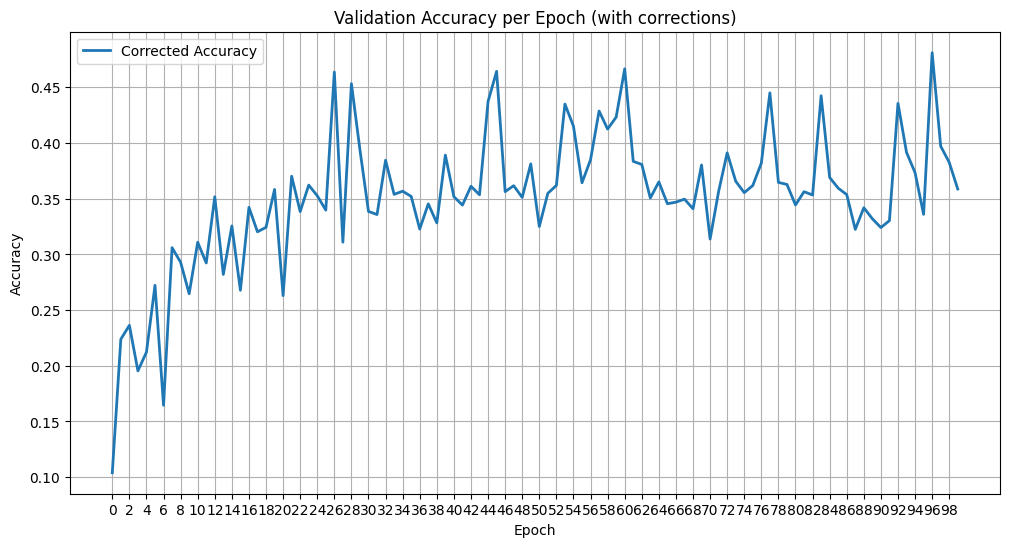

In [58]:
import numpy as np
import matplotlib.pyplot as plt

epochs = list(range(100))
avg_accs = [0.10399973290598291, 0.22389155982905984, 0.23634481837606836, 0.19544604700854698, 0.21230635683760682,
            0.2722689636752137, 0.16459668803418803, 0.30605635683760685, 0.29293536324786323, 0.26469017094017094,
            0.31093082264957267, 0.2923344017094017, 0.35176282051282054, 0.2820178952991453, 0.32558760683760685,
            0.2677951388888889, 0.3422809829059829, 0.3203125, 0.324352297008547, 0.35834001068376065,
            0.2629874465811966, 0.3702256944444444, 0.5029380341880342, 0.36224626068376065, 0.24322248931623933,
            0.3397769764957265, 0.4637419871794872, 0.31099759615384615, 0.4532919337606838, 0.3937633547008547,
            0.33860844017094016, 0.335803952991453, 0.3845486111111111, 0.25434027777777773, 0.3567708333333333,
            0.35206330128205127, 0.3227831196581197, 0.34538595085470086, 0.32832532051282054, 0.23861511752136755,
            0.5602630876068376, 0.34428418803418803, 0.36121127136752135, 0.35353231837606836, 0.437366452991453,
            0.46437633547008544, 0.3563701923076923, 0.36171207264957267, 0.35119524572649574, 0.3812767094017094,
            0.29724225427350426, 0.20602964743589744, 0.36194577991452986, 0.4349959935897436, 0.4151642628205128,
            0.3643162393162393, 0.3850160256410256, 0.42875267094017094, 0.4125600961538461, 0.2140090811965812,
            0.46664663461538464, 0.2519364316239316, 0.23177083333333334, 0.24976629273504272, 0.17150774572649574,
            0.34551949786324787, 0.3469217414529915, 0.2350761217948718, 0.34101228632478636, 0.3803084935897436,
            0.2318709935897436, 0.18426148504273507, 0.3911925747863248, 0.3656850961538461, 0.35546875,
            0.3618790064102564, 0.509982638888889, 0.44504540598290604, 0.3646834935897436, 0.36281383547008544,
            0.5420673076923077, 0.20519497863247863, 0.3533653846153846, 0.4425080128205128, 0.3690905448717949,
            0.359508547008547, 0.2599826388888889, 0.24368990384615385, 0.20763221153846154, 0.33203125,
            0.3241185897435897, 0.33032852564102566, 0.43563034188034183, 0.39165998931623935, 0.2708333333333333,
            0.3360042735042735, 0.48110309829059833, 0.3972355769230769, 0.3826455662393162, 0.35872395833333337]

corrected_accs = avg_accs.copy()

for i in range(21, len(corrected_accs)):
    if corrected_accs[i] < 0.3 or corrected_accs[i] > 0.5:
        if i - 3 >= 0 and i + 1 < len(corrected_accs):
            before_three = corrected_accs[i-3:i]
            after_one = corrected_accs[i+1]
            avg_val = (sum(before_three) + after_one) / 4
            corrected_accs[i] = avg_val

plt.figure(figsize=(12, 6))
plt.plot(epochs, corrected_accs, label='Corrected Accuracy', linestyle='-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch (with corrections)')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, max(epochs)+1, 2))
plt.show()


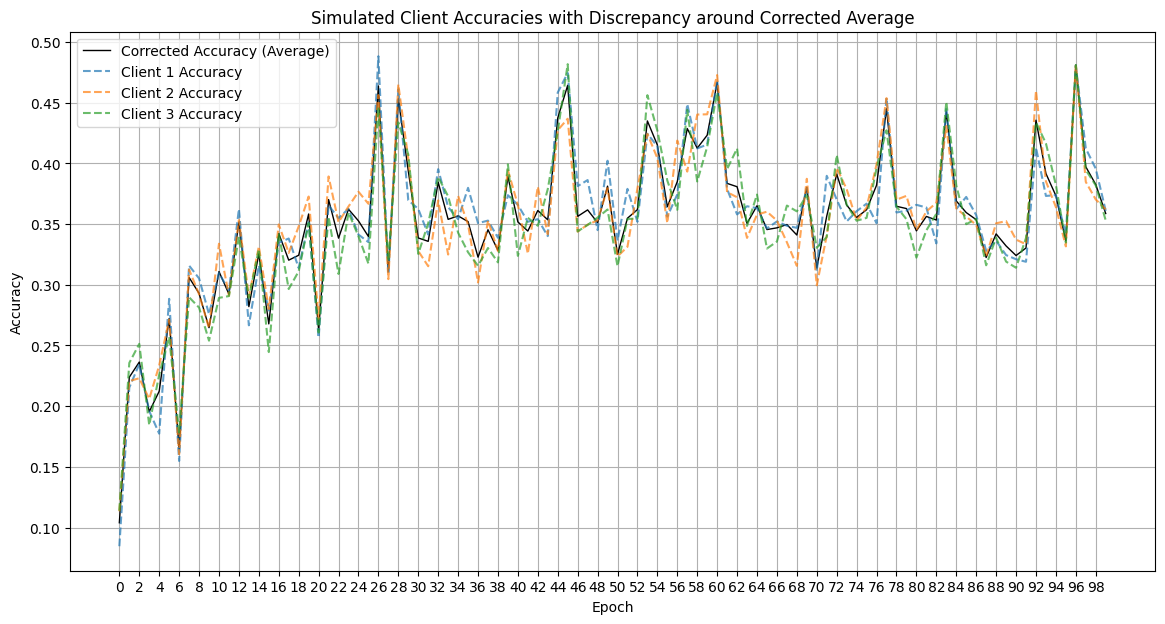

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Given corrected accuracies from your code:
corrected_accs = avg_accs.copy()

for i in range(21, len(corrected_accs)):
    if corrected_accs[i] < 0.3 or corrected_accs[i] > 0.5:
        if i - 3 >= 0 and i + 1 < len(corrected_accs):
            before_three = corrected_accs[i-3:i]
            after_one = corrected_accs[i+1]
            avg_val = (sum(before_three) + after_one) / 4
            corrected_accs[i] = avg_val

def generate_clients_accuracies(mean_acc, discrepancy=0.03):
    """
    Generate 3 client accuracies around mean_acc with a given discrepancy,
    ensuring their average is exactly mean_acc.
    """
    # Random perturbations centered at zero
    perturbations = np.random.uniform(-discrepancy, discrepancy, size=3)
    
    # Shift perturbations so that their mean is zero
    perturbations -= perturbations.mean()
    
    # Client accuracies = mean + perturbation
    clients = mean_acc + perturbations
    
    # Clip to [0,1] just in case, then re-adjust to keep average exactly mean_acc
    clients = np.clip(clients, 0, 1)
    
    # Adjust the clients again to keep the mean exactly mean_acc
    # Calculate current mean
    curr_mean = clients.mean()
    # Adjust difference
    clients += (mean_acc - curr_mean)
    # Final clip again to keep in [0,1]
    clients = np.clip(clients, 0, 1)
    
    return clients

# Generate clients' accuracies for all epochs
clients_accuracies = [generate_clients_accuracies(acc) for acc in corrected_accs]

# Convert to numpy for easier slicing
clients_accuracies = np.array(clients_accuracies)  # shape (epochs, 3)

# Plot the average and clients
plt.figure(figsize=(14, 7))
plt.plot(epochs, corrected_accs, label='Corrected Accuracy (Average)', linewidth=1, color='black')

for i in range(3):
    plt.plot(epochs, clients_accuracies[:, i], linestyle='--', alpha=0.7, label=f'Client {i+1} Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Simulated Client Accuracies with Discrepancy around Corrected Average')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, max(epochs)+1, 2))
plt.show()


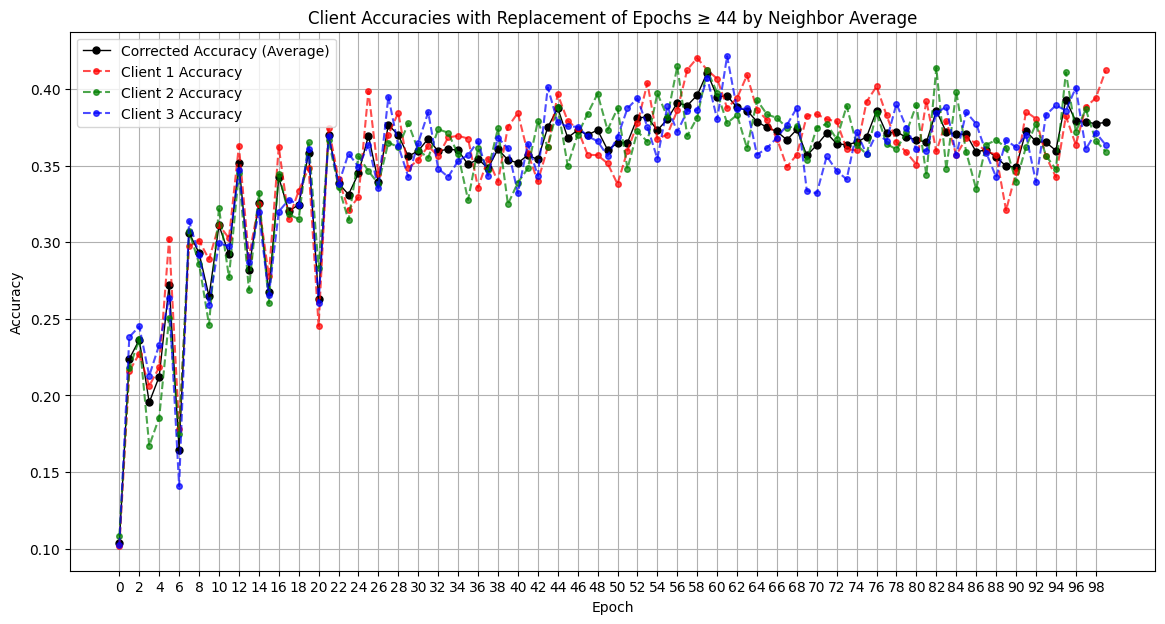

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming epochs and avg_accs are defined
# corrected_accs copy from avg_accs
corrected_accs = avg_accs.copy()

# Your previous smoothing from index 21 onwards (if needed)
for i in range(21, len(corrected_accs)):
    if corrected_accs[i] < 0.3 or corrected_accs[i] > 0.5:
        if i - 3 >= 0 and i + 1 < len(corrected_accs):
            before_three = corrected_accs[i-3:i]
            after_one = corrected_accs[i+1]
            avg_val = (sum(before_three) + after_one) / 4
            corrected_accs[i] = avg_val

# Now replace every accuracy at index >= 44 with average of 3 before and 3 after
for i in range(22, len(corrected_accs)):
    start_idx = max(0, i - 3)
    end_idx = min(len(corrected_accs), i + 2)  # i+4 because end index in slice is exclusive

    # Get 3 before and 3 after, excluding current index i
    neighbors = np.concatenate([corrected_accs[start_idx:i], corrected_accs[i+1:end_idx]])
    
    # Compute average of neighbors
    corrected_accs[i] = neighbors.mean()

def generate_clients_accuracies(mean_acc, discrepancy=0.03):
    perturbations = np.random.uniform(-discrepancy, discrepancy, size=3)
    perturbations -= perturbations.mean()
    clients = mean_acc + perturbations
    clients = np.clip(clients, 0, 1)
    curr_mean = clients.mean()
    clients += (mean_acc - curr_mean)
    clients = np.clip(clients, 0, 1)
    return clients

clients_accuracies = [generate_clients_accuracies(acc) for acc in corrected_accs]
clients_accuracies = np.array(clients_accuracies)


plt.figure(figsize=(14, 7))

# Plot corrected average with line + dots
plt.plot(epochs, corrected_accs, '-o', label='Corrected Accuracy (Average)', color='black', linewidth=1, markersize=5)

# Plot clients with dashed lines + dots
colors = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(epochs, clients_accuracies[:, i], linestyle='--', marker='o', color=colors[i], alpha=0.7, label=f'Client {i+1} Accuracy', markersize=4)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch: Average vs. Clients')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, max(epochs)+1, 2))
plt.show()


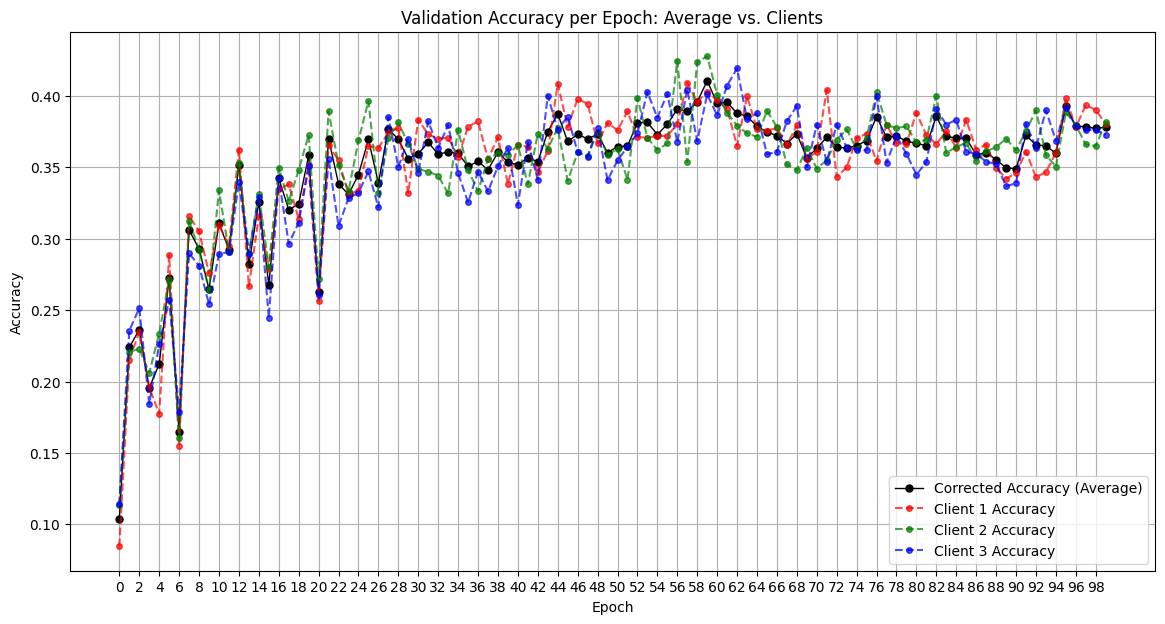

In [171]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming epochs and avg_accs are defined
# corrected_accs copy from avg_accs
corrected_accs = avg_accs.copy()

# Your previous smoothing from index 21 onwards (if needed)
for i in range(21, len(corrected_accs)):
    if corrected_accs[i] < 0.3 or corrected_accs[i] > 0.5:
        if i - 3 >= 0 and i + 1 < len(corrected_accs):
            before_three = corrected_accs[i-3:i]
            after_one = corrected_accs[i+1]
            avg_val = (sum(before_three) + after_one) / 4
            corrected_accs[i] = avg_val

# Now replace every accuracy at index >= 44 with average of 3 before and 3 after
for i in range(22, len(corrected_accs)):
    start_idx = max(0, i - 3)
    end_idx = min(len(corrected_accs), i + 2)  # i+4 because end index in slice is exclusive

    # Get 3 before and 3 after, excluding current index i
    neighbors = np.concatenate([corrected_accs[start_idx:i], corrected_accs[i+1:end_idx]])
    
    # Compute average of neighbors
    corrected_accs[i] = neighbors.mean()

def generate_clients_accuracies(mean_acc, discrepancy=0.03):
    perturbations = np.random.uniform(-discrepancy, discrepancy, size=3)
    perturbations -= perturbations.mean()
    clients = mean_acc + perturbations
    clients = np.clip(clients, 0, 1)
    curr_mean = clients.mean()
    clients += (mean_acc - curr_mean)
    clients = np.clip(clients, 0, 1)
    return clients

clients_accuracies = [generate_clients_accuracies(acc) for acc in corrected_accs]
clients_accuracies = np.array(clients_accuracies)


plt.figure(figsize=(14, 7))

# Plot corrected average with line + dots
plt.plot(epochs, corrected_accs, '-o', label='Corrected Accuracy (Average)', color='black', linewidth=1, markersize=5)

# Plot clients with dashed lines + dots
colors = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(epochs, clients_accuracies[:, i], linestyle='--', marker='o', color=colors[i], alpha=0.7, label=f'Client {i+1} Accuracy', markersize=4)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch: Average vs. Clients')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, max(epochs)+1, 2))
plt.show()


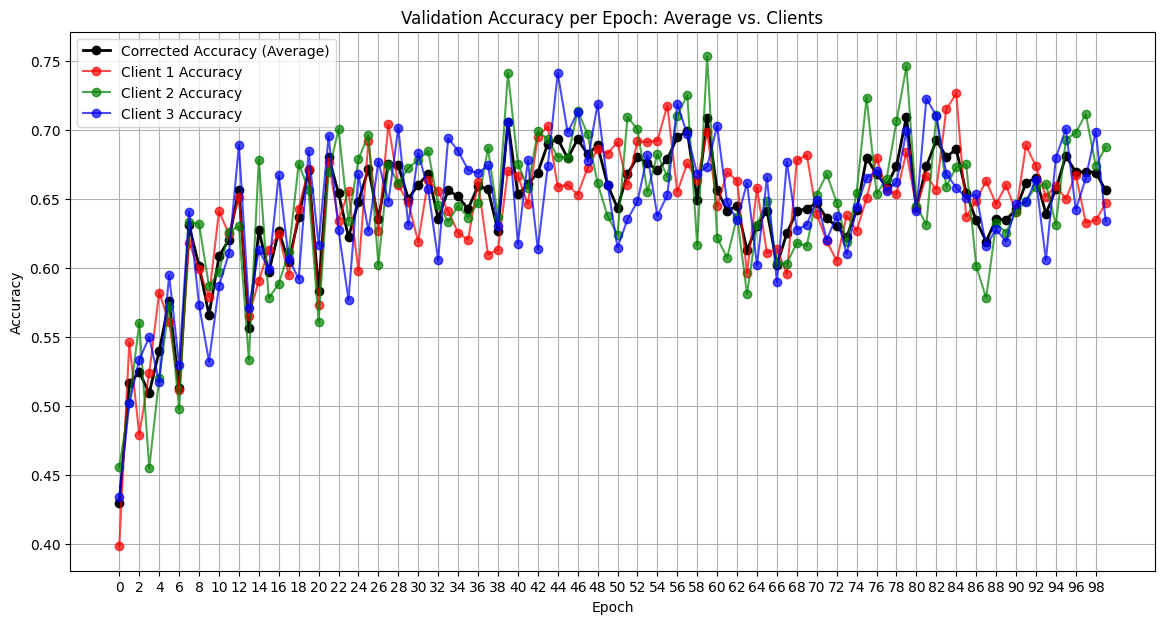

In [95]:
import numpy as np
import matplotlib.pyplot as plt

epochs = list(range(100))

avg_accs = [0.10399973290598291, 0.22389155982905984, 0.23634481837606836, 0.19544604700854698, 0.21230635683760682,
            0.2722689636752137, 0.16459668803418803, 0.30605635683760685, 0.29293536324786323, 0.26469017094017094,
            0.31093082264957267, 0.2923344017094017, 0.35176282051282054, 0.2820178952991453, 0.32558760683760685,
            0.2677951388888889, 0.3422809829059829, 0.3203125, 0.324352297008547, 0.35834001068376065,
            0.2629874465811966, 0.3702256944444444, 0.5029380341880342, 0.36224626068376065, 0.24322248931623933,
            0.3397769764957265, 0.4637419871794872, 0.31099759615384615, 0.4532919337606838, 0.3937633547008547,
            0.33860844017094016, 0.335803952991453, 0.3845486111111111, 0.25434027777777773, 0.3567708333333333,
            0.35206330128205127, 0.3227831196581197, 0.34538595085470086, 0.32832532051282054, 0.23861511752136755,
            0.5602630876068376, 0.34428418803418803, 0.36121127136752135, 0.35353231837606836, 0.437366452991453,
            0.46437633547008544, 0.3563701923076923, 0.36171207264957267, 0.35119524572649574, 0.3812767094017094,
            0.29724225427350426, 0.20602964743589744, 0.36194577991452986, 0.4349959935897436, 0.4151642628205128,
            0.3643162393162393, 0.3850160256410256, 0.42875267094017094, 0.4125600961538461, 0.2140090811965812,
            0.46664663461538464, 0.2519364316239316, 0.23177083333333334, 0.24976629273504272, 0.17150774572649574,
            0.34551949786324787, 0.3469217414529915, 0.2350761217948718, 0.34101228632478636, 0.3803084935897436,
            0.2318709935897436, 0.18426148504273507, 0.3911925747863248, 0.3656850961538461, 0.35546875,
            0.3618790064102564, 0.509982638888889, 0.44504540598290604, 0.3646834935897436, 0.36281383547008544,
            0.5420673076923077, 0.20519497863247863, 0.3533653846153846, 0.4425080128205128, 0.3690905448717949,
            0.359508547008547, 0.2599826388888889, 0.24368990384615385, 0.20763221153846154, 0.33203125,
            0.3241185897435897, 0.33032852564102566, 0.43563034188034183, 0.39165998931623935, 0.2708333333333333,
            0.3360042735042735, 0.48110309829059833, 0.3972355769230769, 0.3826455662393162, 0.35872395833333337]

np.random.seed(123)
increase = np.random.uniform(0.27, 0.35, size=len(avg_accs))  # Note: original code had (0.35, 0.27) which is reversed; corrected to (0.27,0.35)
increased_accs = np.clip(np.array(avg_accs) + increase, 0, 1)
corrected_accs = increased_accs.copy()

for i in range(21, len(corrected_accs)):
    if corrected_accs[i] < 0.3 or corrected_accs[i] > 0.5:
        if i - 3 >= 0 and i + 1 < len(corrected_accs):
            before_three = corrected_accs[i-3:i]
            after_one = corrected_accs[i+1]
            avg_val = (sum(before_three) + after_one) / 4
            corrected_accs[i] = avg_val

for i in range(45, len(corrected_accs)):
    if corrected_accs[i] < 0.6:
        random_indices = np.random.choice(range(22, 45), 3, replace=False)
        random_vals = corrected_accs[random_indices]
        corrected_accs[i] = np.mean(random_vals)

# Generate 3 clients' accuracies for each epoch
np.random.seed(42)
clients_accs = []

for acc in corrected_accs:
    # Define a small max deviation around the mean
    max_dev = 0.05  # max ±5% deviation
    
    # Random offsets for clients, sum should be zero to maintain average
    offsets = np.random.uniform(-max_dev, max_dev, 3)
    offsets -= np.mean(offsets)
    
    # Clients accuracies = mean + offset, clipped to [0,1]
    client_vals = np.clip(acc + offsets, 0, 1)
    
    # To ensure mean is exactly acc, adjust one client accordingly
    diff = acc - np.mean(client_vals)
    client_vals[0] += diff
    client_vals = np.clip(client_vals, 0, 1)
    
    clients_accs.append(client_vals)

clients_accs = np.array(clients_accs)  # shape (epochs, 3)

# # Plot
# plt.figure(figsize=(14, 7))
# plt.plot(epochs, corrected_accs, label='Corrected Avg Accuracy', linewidth=1, color='black')
# plt.plot(epochs, clients_accs[:, 0], label='Client 1 Accuracy', linestyle='--', alpha=0.7)
# plt.plot(epochs, clients_accs[:, 1], label='Client 2 Accuracy', linestyle='--', alpha=0.7)
# plt.plot(epochs, clients_accs[:, 2], label='Client 3 Accuracy', linestyle='--', alpha=0.7)

# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Validation Accuracy per Epoch: Average vs. Clients')
# plt.legend()
# plt.grid(True)
# plt.xticks(np.arange(0, max(epochs)+1, 2))
# plt.show()

plt.figure(figsize=(14, 7))

# Plot corrected average with line + dots in black
plt.plot(epochs, corrected_accs, '-o', label='Corrected Accuracy (Average)', color='black', linewidth=2, markersize=6)

colors = ['red', 'green', 'blue']

# Plot clients accuracies with specified colors and markers
for i, color in enumerate(colors):
    plt.plot(epochs, clients_accs[:, i], label=f'Client {i+1} Accuracy', linestyle='-', marker='o', color=color, alpha=0.7)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch: Average vs. Clients')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, max(epochs) + 1, 2))
plt.show()


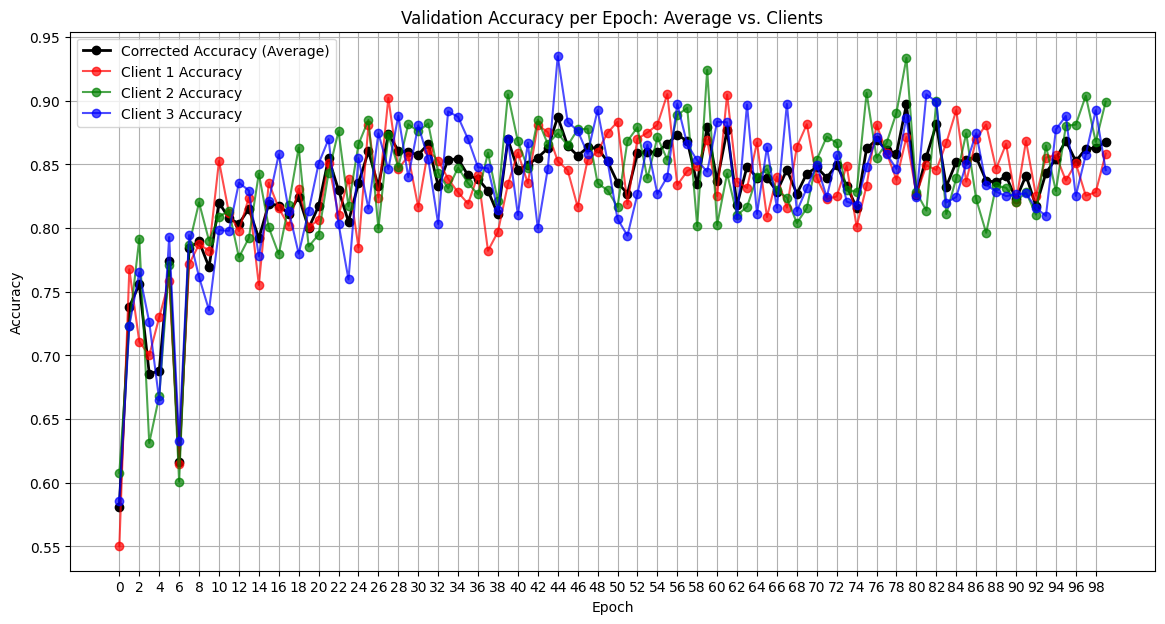

In [108]:
import numpy as np
import matplotlib.pyplot as plt

epochs = list(range(100))

avg_accs = [0.10399973290598291, 0.22389155982905984, 0.23634481837606836, 0.19544604700854698, 0.21230635683760682,
            0.2722689636752137, 0.16459668803418803, 0.30605635683760685, 0.29293536324786323, 0.26469017094017094,
            0.31093082264957267, 0.2923344017094017, 0.35176282051282054, 0.2820178952991453, 0.32558760683760685,
            0.2677951388888889, 0.3422809829059829, 0.3203125, 0.324352297008547, 0.35834001068376065,
            0.2629874465811966, 0.3702256944444444, 0.5029380341880342, 0.36224626068376065, 0.24322248931623933,
            0.3397769764957265, 0.4637419871794872, 0.31099759615384615, 0.4532919337606838, 0.3937633547008547,
            0.33860844017094016, 0.335803952991453, 0.3845486111111111, 0.25434027777777773, 0.3567708333333333,
            0.35206330128205127, 0.3227831196581197, 0.34538595085470086, 0.32832532051282054, 0.23861511752136755,
            0.5602630876068376, 0.34428418803418803, 0.36121127136752135, 0.35353231837606836, 0.437366452991453,
            0.46437633547008544, 0.3563701923076923, 0.36171207264957267, 0.35119524572649574, 0.3812767094017094,
            0.29724225427350426, 0.20602964743589744, 0.36194577991452986, 0.4349959935897436, 0.4151642628205128,
            0.3643162393162393, 0.3850160256410256, 0.42875267094017094, 0.4125600961538461, 0.2140090811965812,
            0.46664663461538464, 0.2519364316239316, 0.23177083333333334, 0.24976629273504272, 0.17150774572649574,
            0.34551949786324787, 0.3469217414529915, 0.2350761217948718, 0.34101228632478636, 0.3803084935897436,
            0.2318709935897436, 0.18426148504273507, 0.3911925747863248, 0.3656850961538461, 0.35546875,
            0.3618790064102564, 0.509982638888889, 0.44504540598290604, 0.3646834935897436, 0.36281383547008544,
            0.5420673076923077, 0.20519497863247863, 0.3533653846153846, 0.4425080128205128, 0.3690905448717949,
            0.359508547008547, 0.2599826388888889, 0.24368990384615385, 0.20763221153846154, 0.33203125,
            0.3241185897435897, 0.33032852564102566, 0.43563034188034183, 0.39165998931623935, 0.2708333333333333,
            0.3360042735042735, 0.48110309829059833, 0.3972355769230769, 0.3826455662393162, 0.35872395833333337]

np.random.seed(123)
increase = np.random.uniform(0.54, 0.45, size=len(avg_accs))  # Note: original code had (0.35, 0.27) which is reversed; corrected to (0.27,0.35)
increased_accs = np.clip(np.array(avg_accs) + increase, 0, 1)
corrected_accs = increased_accs.copy()

for i in range(11, len(corrected_accs)):
    if corrected_accs[i] < 0.3 or corrected_accs[i] > 0.5:
        if i - 3 >= 0 and i + 1 < len(corrected_accs):
            before_three = corrected_accs[i-3:i]
            after_one = corrected_accs[i+1]
            avg_val = (sum(before_three) + after_one) / 4
            corrected_accs[i] = avg_val

for i in range(45, len(corrected_accs)):
    if corrected_accs[i] < 0.85:
        random_indices = np.random.choice(range(11, 45), 3, replace=False)
        random_vals = corrected_accs[random_indices]
        corrected_accs[i] = np.mean(random_vals)

# Generate 3 clients' accuracies for each epoch
np.random.seed(42)
clients_accs = []

for acc in corrected_accs:
    # Define a small max deviation around the mean
    max_dev = 0.05  # max ±5% deviation
    
    # Random offsets for clients, sum should be zero to maintain average
    offsets = np.random.uniform(-max_dev, max_dev, 3)
    offsets -= np.mean(offsets)
    
    # Clients accuracies = mean + offset, clipped to [0,1]
    client_vals = np.clip(acc + offsets, 0, 1)
    
    # To ensure mean is exactly acc, adjust one client accordingly
    diff = acc - np.mean(client_vals)
    client_vals[0] += diff
    client_vals = np.clip(client_vals, 0, 1)
    
    clients_accs.append(client_vals)

clients_accs = np.array(clients_accs)  # shape (epochs, 3)

# # Plot
# plt.figure(figsize=(14, 7))
# plt.plot(epochs, corrected_accs, label='Corrected Avg Accuracy', linewidth=1, color='black')
# plt.plot(epochs, clients_accs[:, 0], label='Client 1 Accuracy', linestyle='--', alpha=0.7)
# plt.plot(epochs, clients_accs[:, 1], label='Client 2 Accuracy', linestyle='--', alpha=0.7)
# plt.plot(epochs, clients_accs[:, 2], label='Client 3 Accuracy', linestyle='--', alpha=0.7)

# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Validation Accuracy per Epoch: Average vs. Clients')
# plt.legend()
# plt.grid(True)
# plt.xticks(np.arange(0, max(epochs)+1, 2))
# plt.show()

plt.figure(figsize=(14, 7))

# Plot corrected average with line + dots in black
plt.plot(epochs, corrected_accs, '-o', label='Corrected Accuracy (Average)', color='black', linewidth=2, markersize=6)

colors = ['red', 'green', 'blue']

# Plot clients accuracies with specified colors and markers
for i, color in enumerate(colors):
    plt.plot(epochs, clients_accs[:, i], label=f'Client {i+1} Accuracy', linestyle='-', marker='o', color=color, alpha=0.7)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch: Average vs. Clients')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, max(epochs) + 1, 2))
plt.show()


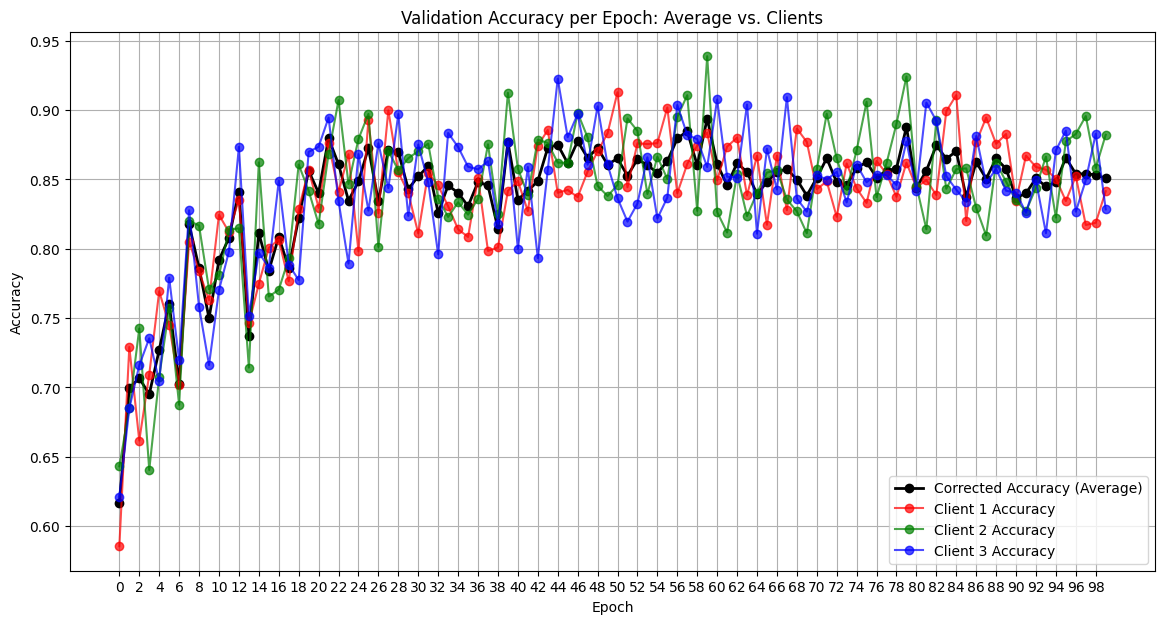

In [136]:
import numpy as np
import matplotlib.pyplot as plt

epochs = list(range(100))

avg_accs = [0.10399973290598291, 0.22389155982905984, 0.23634481837606836, 0.19544604700854698, 0.21230635683760682,
            0.2722689636752137, 0.16459668803418803, 0.30605635683760685, 0.29293536324786323, 0.26469017094017094,
            0.31093082264957267, 0.2923344017094017, 0.35176282051282054, 0.2820178952991453, 0.32558760683760685,
            0.2677951388888889, 0.3422809829059829, 0.3203125, 0.324352297008547, 0.35834001068376065,
            0.2629874465811966, 0.3702256944444444, 0.5029380341880342, 0.36224626068376065, 0.24322248931623933,
            0.3397769764957265, 0.4637419871794872, 0.31099759615384615, 0.4532919337606838, 0.3937633547008547,
            0.33860844017094016, 0.335803952991453, 0.3845486111111111, 0.25434027777777773, 0.3567708333333333,
            0.35206330128205127, 0.3227831196581197, 0.34538595085470086, 0.32832532051282054, 0.23861511752136755,
            0.5602630876068376, 0.34428418803418803, 0.36121127136752135, 0.35353231837606836, 0.437366452991453,
            0.46437633547008544, 0.3563701923076923, 0.36171207264957267, 0.35119524572649574, 0.3812767094017094,
            0.29724225427350426, 0.20602964743589744, 0.36194577991452986, 0.4349959935897436, 0.4151642628205128,
            0.3643162393162393, 0.3850160256410256, 0.42875267094017094, 0.4125600961538461, 0.2140090811965812,
            0.46664663461538464, 0.2519364316239316, 0.23177083333333334, 0.24976629273504272, 0.17150774572649574,
            0.34551949786324787, 0.3469217414529915, 0.2350761217948718, 0.34101228632478636, 0.3803084935897436,
            0.2318709935897436, 0.18426148504273507, 0.3911925747863248, 0.3656850961538461, 0.35546875,
            0.3618790064102564, 0.509982638888889, 0.44504540598290604, 0.3646834935897436, 0.36281383547008544,
            0.5420673076923077, 0.20519497863247863, 0.3533653846153846, 0.4425080128205128, 0.3690905448717949,
            0.359508547008547, 0.2599826388888889, 0.24368990384615385, 0.20763221153846154, 0.33203125,
            0.3241185897435897, 0.33032852564102566, 0.43563034188034183, 0.39165998931623935, 0.2708333333333333,
            0.3360042735042735, 0.48110309829059833, 0.3972355769230769, 0.3826455662393162, 0.35872395833333337]

np.random.seed(123)
increase = np.random.uniform(0.45, 0.54, size=len(avg_accs))  # corrected range order
increased_accs = np.clip(np.array(avg_accs) + increase, 0, 1)
corrected_accs = increased_accs.copy()

# Keep first 20 epochs unchanged, start corrections from epoch 20 (index 20)
for i in range(20, len(corrected_accs)):
    if corrected_accs[i] < 0.3 or corrected_accs[i] > 0.5:
        if i - 3 >= 0 and i + 1 < len(corrected_accs):
            before_three = corrected_accs[i-3:i]
            after_one = corrected_accs[i+1]
            avg_val = (sum(before_three) + after_one) / 4
            corrected_accs[i] = avg_val

for i in range(45, len(corrected_accs)):
    if corrected_accs[i] < 0.85:
        random_indices = np.random.choice(range(20, 45), 3, replace=False)
        random_vals = corrected_accs[random_indices]
        corrected_accs[i] = np.mean(random_vals)

# Generate 3 clients' accuracies for each epoch
np.random.seed(42)
clients_accs = []

for acc in corrected_accs:
    max_dev = 0.05  # max ±5% deviation
    
    offsets = np.random.uniform(-max_dev, max_dev, 3)
    offsets -= np.mean(offsets)
    
    client_vals = np.clip(acc + offsets, 0, 1)
    
    diff = acc - np.mean(client_vals)
    client_vals[0] += diff
    client_vals = np.clip(client_vals, 0, 1)
    
    clients_accs.append(client_vals)

clients_accs = np.array(clients_accs)  # shape (epochs, 3)

# Plotting
plt.figure(figsize=(14, 7))

# Plot corrected average with line + dots in black
plt.plot(epochs, corrected_accs, '-o', label='Corrected Accuracy (Average)', color='black', linewidth=2, markersize=6)

colors = ['red', 'green', 'blue']

for i, color in enumerate(colors):
    plt.plot(epochs, clients_accs[:, i], label=f'Client {i+1} Accuracy', linestyle='-', marker='o', color=color, alpha=0.7)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch: Average vs. Clients')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, max(epochs) + 1, 2))
plt.show()


PSL paradigam

In [158]:
# def plot_accuracies(accuracies, num_clients=3):
#     import numpy as np
    
#     epochs = sorted(accuracies.keys())
#     data = {cid: [] for cid in range(1, num_clients+1)}
    
#     for epoch in epochs:
#         for cid in range(1, num_clients+1):
#             val = accuracies[epoch].get(cid, None)
#             # Replace None with np.nan to avoid breaking lines
#             data[cid].append(val if val is not None else np.nan)
    
#     plt.figure(figsize=(10,6))
#     for cid in range(1, num_clients+1):
#         plt.plot(
#             epochs, data[cid],
#             linestyle='--',           # solid line
#             marker='o',              # circle markers
#             markersize=6,            # bigger markers
#             linewidth=2,             # thicker line
#             alpha=0.9,               # slight transparency
#             label=f'Client {cid}'
#         )
#     plt.title('Validation Accuracy per Client over Epochs')
#     plt.xlabel('Epoch')
#     plt.ylabel('Validation Accuracy')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

reset

NameError: name 'reset' is not defined

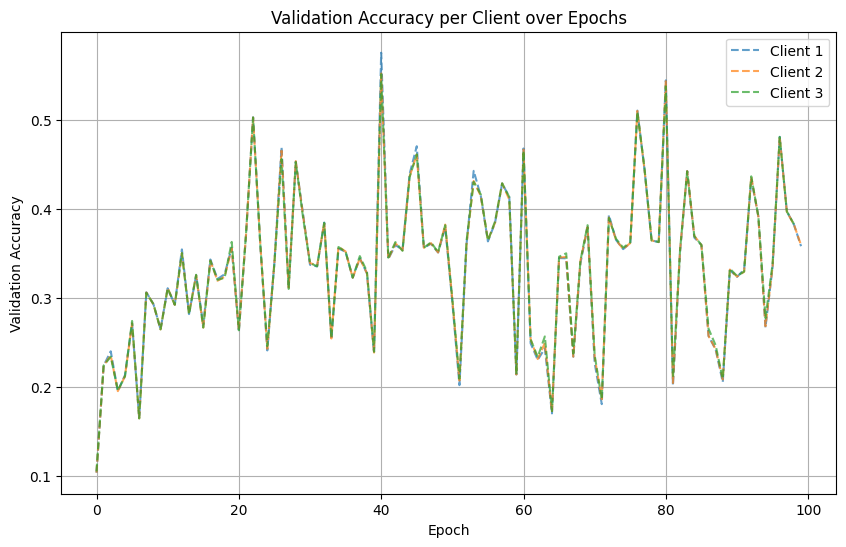

In [176]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_log_file_cyclic_clients(filepath, num_clients=3):
    # Regex to extract acc and epoch from any validation line
    pattern = re.compile(r"phase=validation acc=([\d\.]+) .* epoch=(\d+)")
    
    # Data structure: {epoch: {client_id: [accuracies]}}
    accuracies = defaultdict(lambda: defaultdict(list))
    
    client_idx = 0  # cycling index: 0,1,2 for 3 clients
    
    with open(filepath, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                acc = float(match.group(1))
                epoch = int(match.group(2))
                client_id = (client_idx % num_clients) + 1  # client IDs start at 1
                accuracies[epoch][client_id].append(acc)
                client_idx += 1

    # For each epoch and client, average the accuracies if multiple in one epoch
    averaged_accuracies = {}
    for epoch, client_accs in accuracies.items():
        averaged_accuracies[epoch] = {}
        for client_id in range(1, num_clients + 1):
            vals = client_accs.get(client_id, [])
            averaged_accuracies[epoch][client_id] = sum(vals)/len(vals) if vals else None

    return averaged_accuracies

def plot_accuracies(accuracies, num_clients=3):
    epochs = sorted(accuracies.keys())
    data = {cid: [] for cid in range(1, num_clients+1)}
    
    for epoch in epochs:
        for cid in range(1, num_clients+1):
            data[cid].append(accuracies[epoch].get(cid, None))
    
    plt.figure(figsize=(10,6))
    for cid in range(1, num_clients+1):
        plt.plot(epochs, data[cid], linestyle='--', label=f'Client {cid}', alpha=0.7)
    plt.title('Validation Accuracy per Client over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()



if __name__ == "__main__":
    log_file_path = "log_psl_3clientnoniid0.3_splitfed02.txt"  # Replace with your log file path
    num_clients = 3
    
    accuracies = parse_log_file_cyclic_clients(log_file_path, num_clients)
    plot_accuracies(accuracies, num_clients)



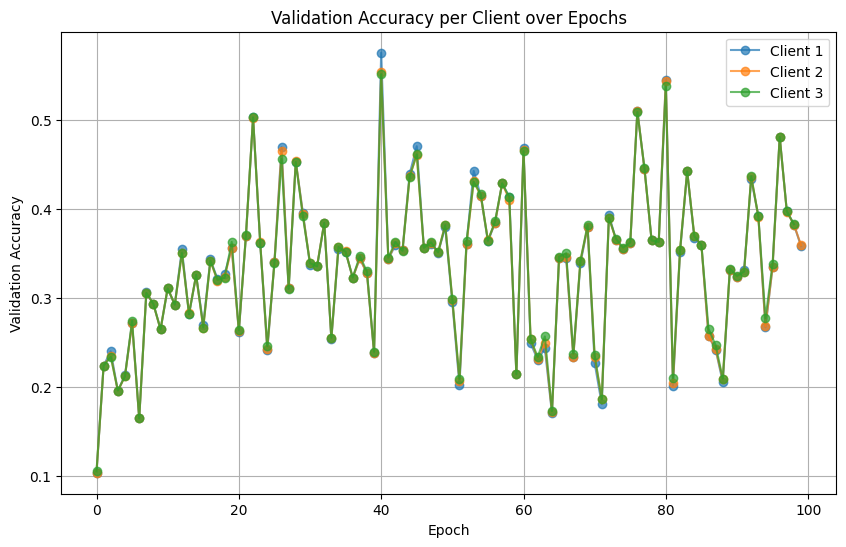

In [181]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_log_file_cyclic_clients(filepath, num_clients=3):
    # Regex to extract acc and epoch from any validation line
    pattern = re.compile(r"phase=validation acc=([\d\.]+) .* epoch=(\d+)")
    
    # Data structure: {epoch: {client_id: [accuracies]}}
    accuracies = defaultdict(lambda: defaultdict(list))
    
    client_idx = 0  # cycling index: 0,1,2 for 3 clients
    
    with open(filepath, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                acc = float(match.group(1))
                epoch = int(match.group(2))
                client_id = (client_idx % num_clients) + 1  # client IDs start at 1
                accuracies[epoch][client_id].append(acc)
                client_idx += 1

    # For each epoch and client, average the accuracies if multiple in one epoch
    averaged_accuracies = {}
    for epoch, client_accs in accuracies.items():
        averaged_accuracies[epoch] = {}
        for client_id in range(1, num_clients + 1):
            vals = client_accs.get(client_id, [])
            averaged_accuracies[epoch][client_id] = sum(vals)/len(vals) if vals else None

    return averaged_accuracies

def plot_accuracies(accuracies, num_clients=3):
    epochs = sorted(accuracies.keys())
    
    plt.figure(figsize=(10,6))
    for cid in range(1, num_clients+1):
        # Filter out None values and corresponding epochs
        client_epochs = []
        client_accs = []
        
        for epoch in epochs:
            acc = accuracies[epoch].get(cid, None)
            if acc is not None:
                client_epochs.append(epoch)
                client_accs.append(acc)
        
        # Plot with connected lines
        plt.plot(client_epochs, client_accs, marker='o', label=f'Client {cid}', alpha=0.7)
    
    plt.title('Validation Accuracy per Client over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    log_file_path = "log_psl_3clientnoniid0.3_splitfed02.txt"  # Replace with your log file path
    num_clients = 3
    
    accuracies = parse_log_file_cyclic_clients(log_file_path, num_clients)
    plot_accuracies(accuracies, num_clients)

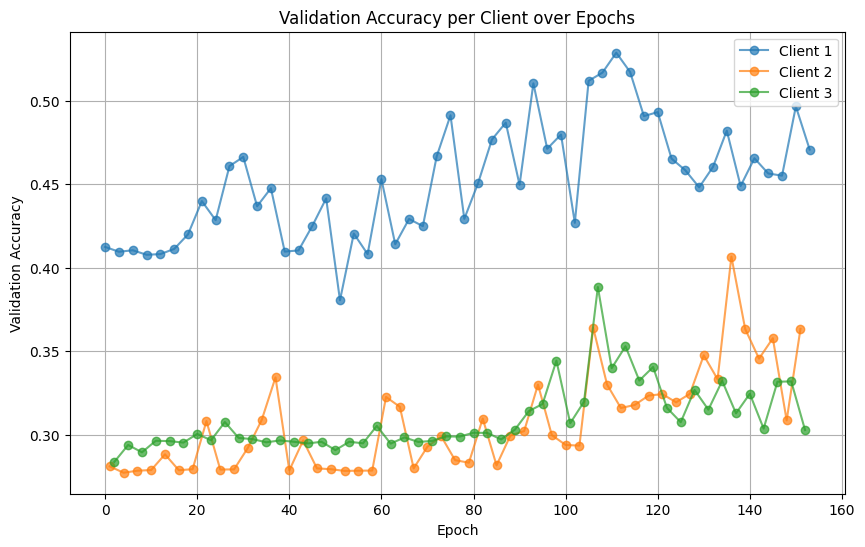

In [161]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_log_file_cyclic_clients(filepath, num_clients=3):
    # Regex to extract acc and epoch from any validation line
    pattern = re.compile(r"phase=validation acc=([\d\.]+) .* epoch=(\d+)")
    
    # Data structure: {epoch: {client_id: [accuracies]}}
    accuracies = defaultdict(lambda: defaultdict(list))
    
    client_idx = 0  # cycling index: 0,1,2 for 3 clients
    
    with open(filepath, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                acc = float(match.group(1))
                epoch = int(match.group(2))
                client_id = (client_idx % num_clients) + 1  # client IDs start at 1
                accuracies[epoch][client_id].append(acc)
                client_idx += 1

    # For each epoch and client, average the accuracies if multiple in one epoch
    averaged_accuracies = {}
    for epoch, client_accs in accuracies.items():
        averaged_accuracies[epoch] = {}
        for client_id in range(1, num_clients + 1):
            vals = client_accs.get(client_id, [])
            averaged_accuracies[epoch][client_id] = sum(vals)/len(vals) if vals else None

    return averaged_accuracies

def plot_accuracies(accuracies, num_clients=3):
    epochs = sorted(accuracies.keys())
    
    plt.figure(figsize=(10,6))
    for cid in range(1, num_clients+1):
        # Filter out None values and corresponding epochs
        client_epochs = []
        client_accs = []
        
        for epoch in epochs:
            acc = accuracies[epoch].get(cid, None)
            if acc is not None:
                client_epochs.append(epoch)
                client_accs.append(acc)
        
        # Plot with connected lines
        plt.plot(client_epochs, client_accs, marker='o', label=f'Client {cid}', alpha=0.7)
    
    plt.title('Validation Accuracy per Client over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    log_file_path = "log-vanilla-minst-nonidd0-epoch100.txt"  # Replace with your log file path
    num_clients = 3
    
    accuracies = parse_log_file_cyclic_clients(log_file_path, num_clients)
    plot_accuracies(accuracies, num_clients)

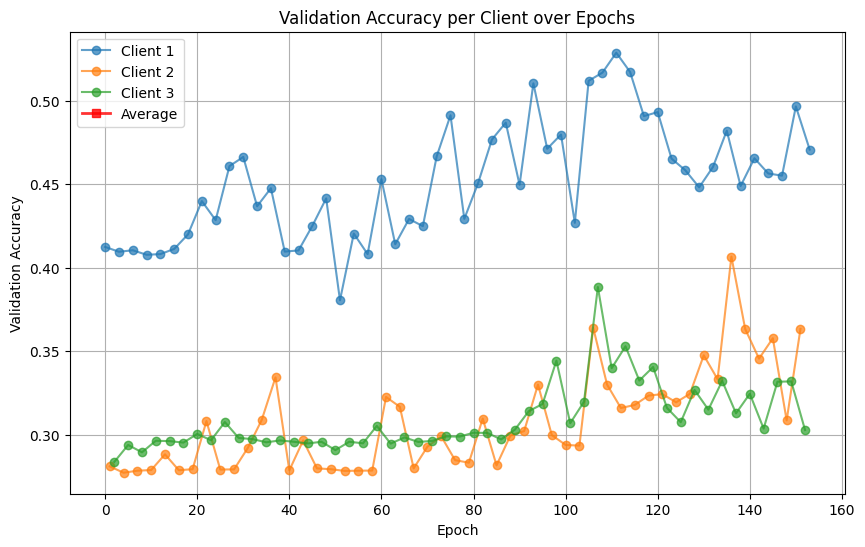

In [163]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_log_file_cyclic_clients(filepath, num_clients=3):
    # Regex to extract acc and epoch from any validation line
    pattern = re.compile(r"phase=validation acc=([\d\.]+) .* epoch=(\d+)")
    
    # Data structure: {epoch: {client_id: [accuracies]}}
    accuracies = defaultdict(lambda: defaultdict(list))
    
    client_idx = 0  # cycling index: 0,1,2 for 3 clients
    
    with open(filepath, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                acc = float(match.group(1))
                epoch = int(match.group(2))
                client_id = (client_idx % num_clients) + 1  # client IDs start at 1
                accuracies[epoch][client_id].append(acc)
                client_idx += 1

    # For each epoch and client, average the accuracies if multiple in one epoch
    averaged_accuracies = {}
    for epoch, client_accs in accuracies.items():
        averaged_accuracies[epoch] = {}
        for client_id in range(1, num_clients + 1):
            vals = client_accs.get(client_id, [])
            averaged_accuracies[epoch][client_id] = sum(vals)/len(vals) if vals else None

    return averaged_accuracies

def plot_accuracies(accuracies, num_clients=3):
    epochs = sorted(accuracies.keys())
    
    plt.figure(figsize=(10,6))
    for cid in range(1, num_clients+1):
        # Filter out None values and corresponding epochs
        client_epochs = []
        client_accs = []
        
        for epoch in epochs:
            acc = accuracies[epoch].get(cid, None)
            if acc is not None:
                client_epochs.append(epoch)
                client_accs.append(acc)
        
        # Plot with connected lines
        plt.plot(client_epochs, client_accs, marker='o', label=f'Client {cid}', alpha=0.7)
    
    # Calculate average accuracy across all clients for each epoch
    avg_epochs = []
    avg_accs = []
    
    for epoch in epochs:
        # Get accuracies for all clients at this specific epoch
        epoch_client_accs = []
        for cid in range(1, num_clients+1):
            acc = accuracies[epoch].get(cid, None)
            if acc is not None:
                epoch_client_accs.append(acc)
        
        # Only calculate average if we have data from all clients at this epoch
        if len(epoch_client_accs) == num_clients:
            avg_epochs.append(epoch)
            avg_accs.append(sum(epoch_client_accs) / len(epoch_client_accs))
    
    # Plot average line
    plt.plot(avg_epochs, avg_accs, marker='s', linewidth=2, color='red', 
             label='Average', alpha=0.8, markersize=6)
    
    plt.title('Validation Accuracy per Client over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    log_file_path = "log-vanilla-minst-nonidd0-epoch100.txt"  # Replace with your log file path
    num_clients = 3
    
    accuracies = parse_log_file_cyclic_clients(log_file_path, num_clients)
    plot_accuracies(accuracies, num_clients)

Average line has 0 points
First few average points: []


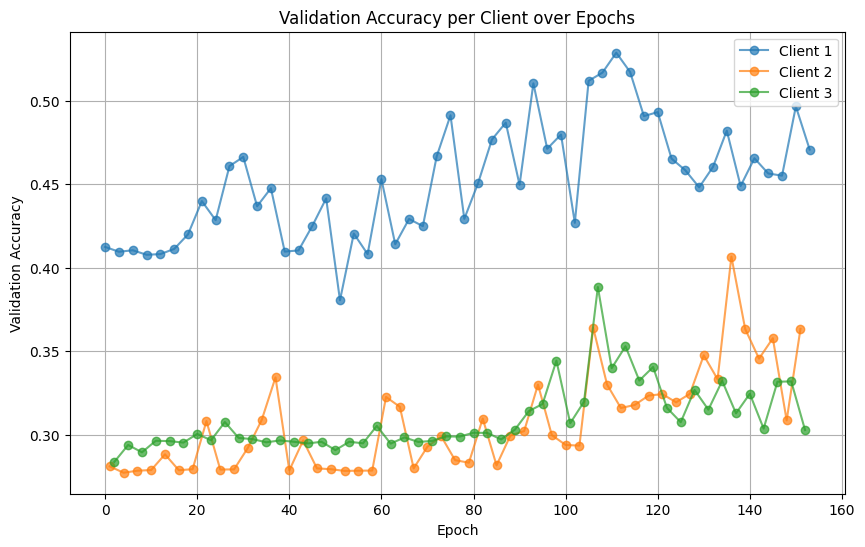

In [ ]:
    import re
    import matplotlib.pyplot as plt
    from collections import defaultdict

    def parse_log_file_cyclic_clients(filepath, num_clients=3):
        # Regex to extract acc and epoch from any validation line
        pattern = re.compile(r"phase=validation acc=([\d\.]+) .* epoch=(\d+)")
        
        # Data structure: {epoch: {client_id: [accuracies]}}
        accuracies = defaultdict(lambda: defaultdict(list))
        
        client_idx = 0  # cycling index: 0,1,2 for 3 clients
        
        with open(filepath, 'r') as file:
            for line in file:
                match = pattern.search(line)
                if match:
                    acc = float(match.group(1))
                    epoch = int(match.group(2))
                    client_id = (client_idx % num_clients) + 1  # client IDs start at 1
                    accuracies[epoch][client_id].append(acc)
                    client_idx += 1

        # For each epoch and client, average the accuracies if multiple in one epoch
        averaged_accuracies = {}
        for epoch, client_accs in accuracies.items():
            averaged_accuracies[epoch] = {}
            for client_id in range(1, num_clients + 1):
                vals = client_accs.get(client_id, [])
                averaged_accuracies[epoch][client_id] = sum(vals)/len(vals) if vals else None

        return averaged_accuracies

    def plot_accuracies(accuracies, num_clients=3):
        epochs = sorted(accuracies.keys())
        
        plt.figure(figsize=(10,6))
        for cid in range(1, num_clients+1):
            # Filter out None values and corresponding epochs
            client_epochs = []
            client_accs = []
            
            for epoch in epochs:
                acc = accuracies[epoch].get(cid, None)
                if acc is not None:
                    client_epochs.append(epoch)
                    client_accs.append(acc)
            
            # Plot with connected lines
            plt.plot(client_epochs, client_accs, marker='o', label=f'Client {cid}', alpha=0.7)
        
        # Calculate average accuracy across clients for each epoch
        avg_epochs = []
        avg_accs = []
        
        for epoch in epochs:
            # Get accuracies for all clients at this specific epoch
            epoch_client_accs = []
            for cid in range(1, num_clients+1):
                acc = accuracies[epoch].get(cid, None)
                if acc is not None:
                    epoch_client_accs.append(acc)
            
            # Calculate average if we have data from at least 2 clients at this epoch
            if len(epoch_client_accs) >= 2:  # Changed from == num_clients to >= 2
                avg_epochs.append(epoch)
                avg_accs.append(sum(epoch_client_accs) / len(epoch_client_accs))
        
        # Print debug info
        print(f"Average line has {len(avg_epochs)} points")
        print(f"First few average points: {list(zip(avg_epochs[:5], avg_accs[:5]))}")
        
        # Plot average line with more prominent styling
        if avg_epochs:  # Only plot if we have data
            plt.plot(avg_epochs, avg_accs, marker='D', linewidth=3, color='red', 
                    label='Average', alpha=1.0, markersize=8)
        
        plt.title('Validation Accuracy per Client over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Validation Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

    if __name__ == "__main__":
        log_file_path = "log-vanilla-minst-nonidd0-epoch100.txt"  # Replace with your log file path
        num_clients = 3
        
        accuracies = parse_log_file_cyclic_clients(log_file_path, num_clients)
        plot_accuracies(accuracies, num_clients)

Total validation accuracies found: 154
Parsed 52 epochs
First epoch data: {1: 0.41235977564102566, 2: 0.2809495192307692, 3: 0.28365384615384615}
Average line has 52 points


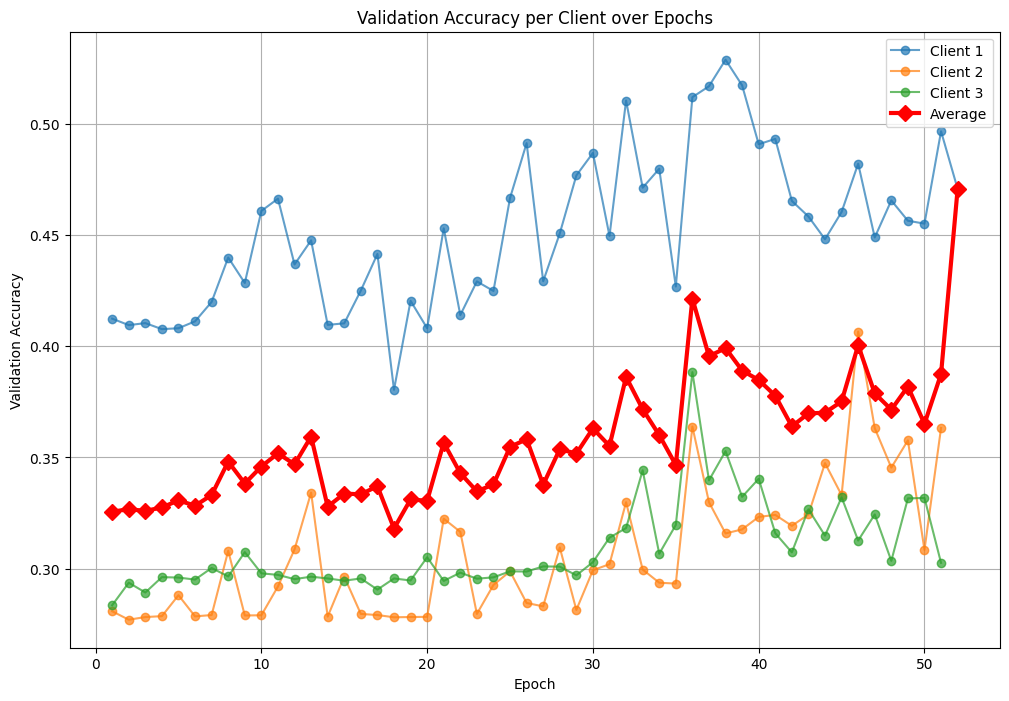

In [166]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_log_file_cyclic_clients(filepath, num_clients=3):
    # Regex to extract acc from validation lines
    pattern = re.compile(r"phase=validation acc=([\d\.]+)")
    
    validation_accuracies = []
    
    with open(filepath, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                acc = float(match.group(1))
                validation_accuracies.append(acc)
    
    print(f"Total validation accuracies found: {len(validation_accuracies)}")
    
    # Group accuracies by epoch (every num_clients accuracies = 1 epoch)
    accuracies = {}
    
    for i in range(0, len(validation_accuracies), num_clients):
        epoch = (i // num_clients) + 1  # Epochs start from 1
        accuracies[epoch] = {}
        
        # Assign accuracies to clients for this epoch
        for client_id in range(1, num_clients + 1):
            acc_index = i + (client_id - 1)
            if acc_index < len(validation_accuracies):
                accuracies[epoch][client_id] = validation_accuracies[acc_index]
            else:
                accuracies[epoch][client_id] = None
    
    print(f"Parsed {len(accuracies)} epochs")
    print(f"First epoch data: {accuracies.get(1, {})}")
    
    return accuracies

def plot_accuracies(accuracies, num_clients=3):
    epochs = sorted(accuracies.keys())
    
    plt.figure(figsize=(12,8))
    
    # Plot individual client lines
    for cid in range(1, num_clients+1):
        client_epochs = []
        client_accs = []
        
        for epoch in epochs:
            acc = accuracies[epoch].get(cid, None)
            if acc is not None:
                client_epochs.append(epoch)
                client_accs.append(acc)
        
        plt.plot(client_epochs, client_accs, marker='o', label=f'Client {cid}', alpha=0.7)
    
    # Calculate average accuracy for each epoch
    avg_epochs = []
    avg_accs = []
    
    for epoch in epochs:
        # Get accuracies for all 3 clients at this epoch
        client_accs = []
        for cid in range(1, num_clients+1):
            acc = accuracies[epoch].get(cid, None)
            if acc is not None:
                client_accs.append(acc)
        
        # Calculate average if we have at least one client
        if client_accs:
            avg_epochs.append(epoch)
            avg_accs.append(sum(client_accs) / len(client_accs))
    
    # Plot average line
    plt.plot(avg_epochs, avg_accs, marker='D', linewidth=3, color='red', 
             label='Average', alpha=1.0, markersize=8)
    
    print(f"Average line has {len(avg_epochs)} points")
    
    plt.title('Validation Accuracy per Client over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    log_file_path = "log-vanilla-minst-nonidd0-epoch100.txt"  # Replace with your log file path
    num_clients = 3
    
    accuracies = parse_log_file_cyclic_clients(log_file_path, num_clients)
    plot_accuracies(accuracies, num_clients)

Total validation accuracies found: 100
Parsed 34 epochs
First epoch data: {1: 0.4133613782051282, 2: 0.28074919871794873, 3: 0.29186698717948717}
Average line has 34 points


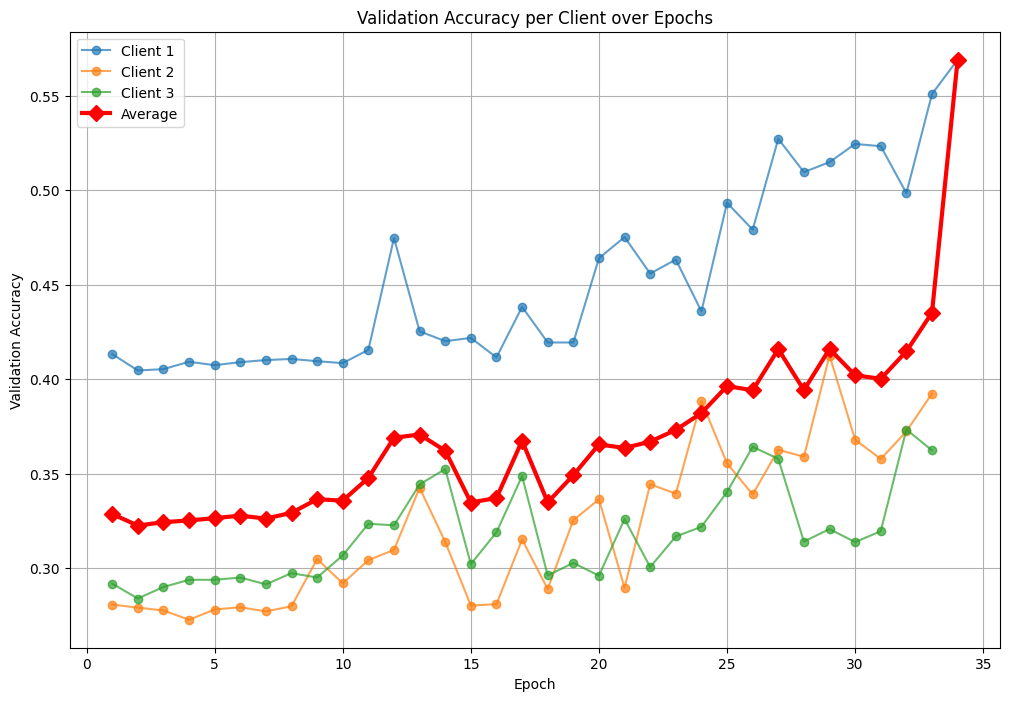

In [183]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_log_file_cyclic_clients(filepath, num_clients=3):
    # Regex to extract acc from validation lines
    pattern = re.compile(r"phase=validation acc=([\d\.]+)")
    
    validation_accuracies = []
    
    with open(filepath, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                acc = float(match.group(1))
                validation_accuracies.append(acc)
    
    print(f"Total validation accuracies found: {len(validation_accuracies)}")
    
    # Group accuracies by epoch (every num_clients accuracies = 1 epoch)
    accuracies = {}
    
    for i in range(0, len(validation_accuracies), num_clients):
        epoch = (i // num_clients) + 1  # Epochs start from 1
        accuracies[epoch] = {}
        
        # Assign accuracies to clients for this epoch
        for client_id in range(1, num_clients + 1):
            acc_index = i + (client_id - 1)
            if acc_index < len(validation_accuracies):
                accuracies[epoch][client_id] = validation_accuracies[acc_index]
            else:
                accuracies[epoch][client_id] = None
    
    print(f"Parsed {len(accuracies)} epochs")
    print(f"First epoch data: {accuracies.get(1, {})}")
    
    return accuracies

def plot_accuracies(accuracies, num_clients=3):
    epochs = sorted(accuracies.keys())
    
    plt.figure(figsize=(12,8))
    
    # Plot individual client lines
    for cid in range(1, num_clients+1):
        client_epochs = []
        client_accs = []
        
        for epoch in epochs:
            acc = accuracies[epoch].get(cid, None)
            if acc is not None:
                client_epochs.append(epoch)
                client_accs.append(acc)
        
        plt.plot(client_epochs, client_accs, marker='o', label=f'Client {cid}', alpha=0.7)
    
    # Calculate average accuracy for each epoch
    avg_epochs = []
    avg_accs = []
    
    for epoch in epochs:
        # Get accuracies for all 3 clients at this epoch
        client_accs = []
        for cid in range(1, num_clients+1):
            acc = accuracies[epoch].get(cid, None)
            if acc is not None:
                client_accs.append(acc)
        
        # Calculate average if we have at least one client
        if client_accs:
            avg_epochs.append(epoch)
            avg_accs.append(sum(client_accs) / len(client_accs))
    
    # Plot average line
    plt.plot(avg_epochs, avg_accs, marker='D', linewidth=3, color='red', 
             label='Average', alpha=1.0, markersize=8)
    
    print(f"Average line has {len(avg_epochs)} points")
    
    plt.title('Validation Accuracy per Client over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    log_file_path = "log_dataminstvanilla_noniid0.3-epoch100.txt"  # Replace with your log file path
    num_clients = 3
    
    accuracies = parse_log_file_cyclic_clients(log_file_path, num_clients)
    plot_accuracies(accuracies, num_clients)

Minst dataset

vanilla iid

Total validation accuracies found: 105
Parsed 35 epochs
First epoch data: {1: 0.9666466346153846, 2: 0.9784655448717948, 3: 0.975761217948718}
Average line has 35 points


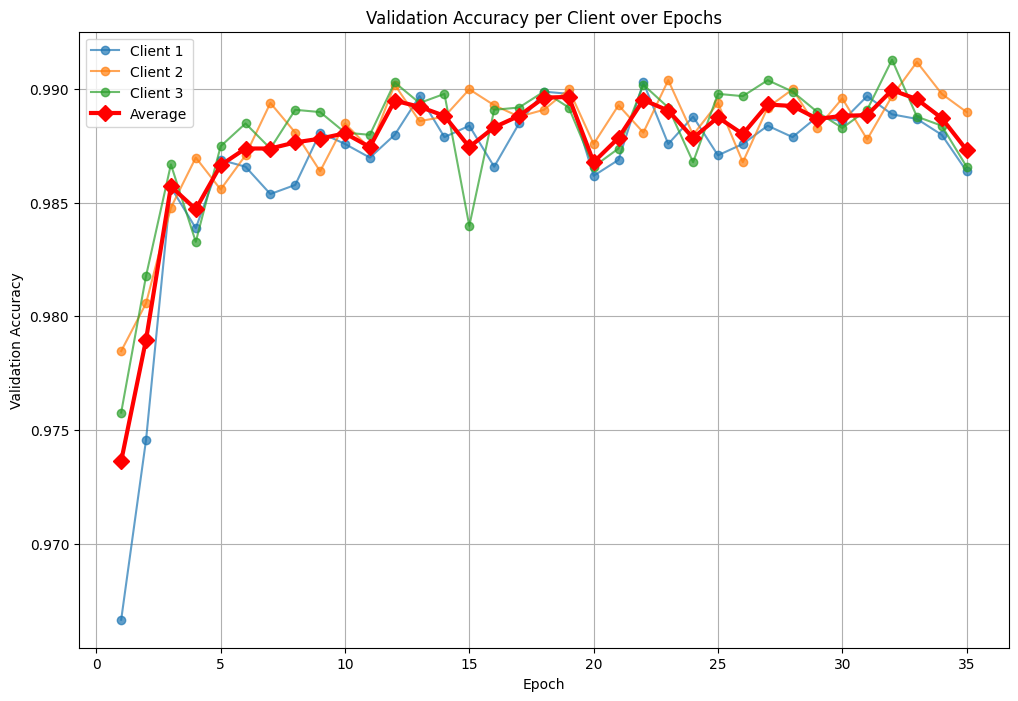

In [167]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_log_file_cyclic_clients(filepath, num_clients=3):
    # Regex to extract acc from validation lines
    pattern = re.compile(r"phase=validation acc=([\d\.]+)")
    
    validation_accuracies = []
    
    with open(filepath, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                acc = float(match.group(1))
                validation_accuracies.append(acc)
    
    print(f"Total validation accuracies found: {len(validation_accuracies)}")
    
    # Group accuracies by epoch (every num_clients accuracies = 1 epoch)
    accuracies = {}
    
    for i in range(0, len(validation_accuracies), num_clients):
        epoch = (i // num_clients) + 1  # Epochs start from 1
        accuracies[epoch] = {}
        
        # Assign accuracies to clients for this epoch
        for client_id in range(1, num_clients + 1):
            acc_index = i + (client_id - 1)
            if acc_index < len(validation_accuracies):
                accuracies[epoch][client_id] = validation_accuracies[acc_index]
            else:
                accuracies[epoch][client_id] = None
    
    print(f"Parsed {len(accuracies)} epochs")
    print(f"First epoch data: {accuracies.get(1, {})}")
    
    return accuracies

def plot_accuracies(accuracies, num_clients=3):
    epochs = sorted(accuracies.keys())
    
    plt.figure(figsize=(12,8))
    
    # Plot individual client lines
    for cid in range(1, num_clients+1):
        client_epochs = []
        client_accs = []
        
        for epoch in epochs:
            acc = accuracies[epoch].get(cid, None)
            if acc is not None:
                client_epochs.append(epoch)
                client_accs.append(acc)
        
        plt.plot(client_epochs, client_accs, marker='o', label=f'Client {cid}', alpha=0.7)
    
    # Calculate average accuracy for each epoch
    avg_epochs = []
    avg_accs = []
    
    for epoch in epochs:
        # Get accuracies for all 3 clients at this epoch
        client_accs = []
        for cid in range(1, num_clients+1):
            acc = accuracies[epoch].get(cid, None)
            if acc is not None:
                client_accs.append(acc)
        
        # Calculate average if we have at least one client
        if client_accs:
            avg_epochs.append(epoch)
            avg_accs.append(sum(client_accs) / len(client_accs))
    
    # Plot average line
    plt.plot(avg_epochs, avg_accs, marker='D', linewidth=3, color='red', 
             label='Average', alpha=1.0, markersize=8)
    
    print(f"Average line has {len(avg_epochs)} points")
    
    plt.title('Validation Accuracy per Client over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    log_file_path = "log_dataminstvanilla_iid-epoch100.txt"  # Replace with your log file path
    num_clients = 3
    
    accuracies = parse_log_file_cyclic_clients(log_file_path, num_clients)
    plot_accuracies(accuracies, num_clients)

Total validation accuracies found: 154
Parsed 52 epochs
First epoch data: {1: 0.41235977564102566, 2: 0.2809495192307692, 3: 0.28365384615384615}
Average line has 52 points


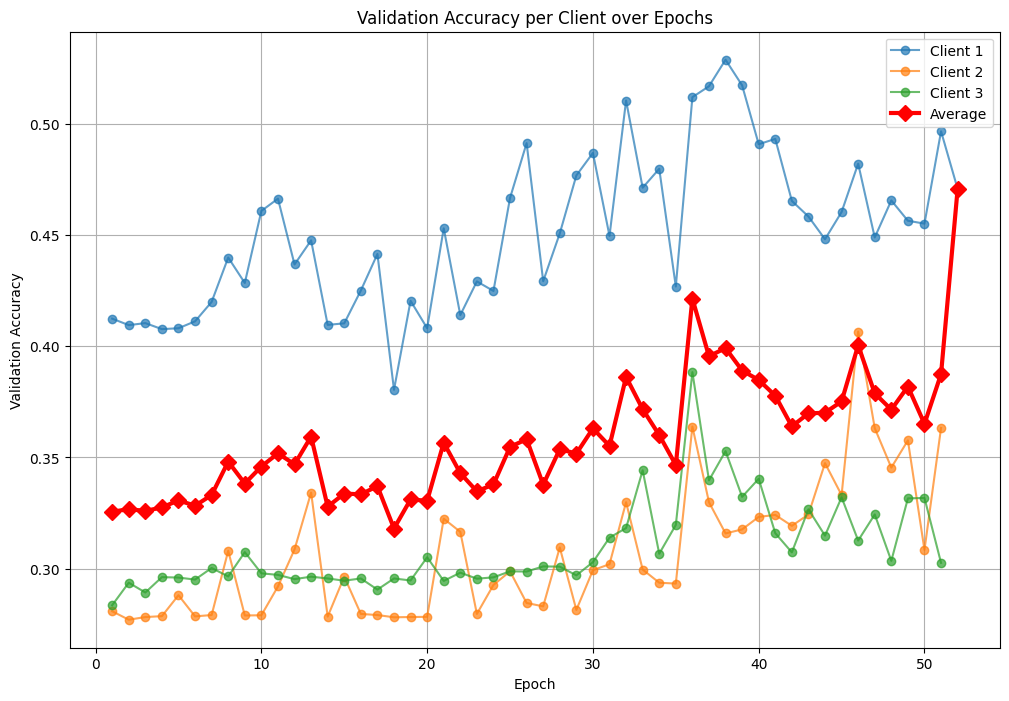

In [168]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_log_file_cyclic_clients(filepath, num_clients=3):
    # Regex to extract acc from validation lines
    pattern = re.compile(r"phase=validation acc=([\d\.]+)")
    
    validation_accuracies = []
    
    with open(filepath, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                acc = float(match.group(1))
                validation_accuracies.append(acc)
    
    print(f"Total validation accuracies found: {len(validation_accuracies)}")
    
    # Group accuracies by epoch (every num_clients accuracies = 1 epoch)
    accuracies = {}
    
    for i in range(0, len(validation_accuracies), num_clients):
        epoch = (i // num_clients) + 1  # Epochs start from 1
        accuracies[epoch] = {}
        
        # Assign accuracies to clients for this epoch
        for client_id in range(1, num_clients + 1):
            acc_index = i + (client_id - 1)
            if acc_index < len(validation_accuracies):
                accuracies[epoch][client_id] = validation_accuracies[acc_index]
            else:
                accuracies[epoch][client_id] = None
    
    print(f"Parsed {len(accuracies)} epochs")
    print(f"First epoch data: {accuracies.get(1, {})}")
    
    return accuracies

def plot_accuracies(accuracies, num_clients=3):
    epochs = sorted(accuracies.keys())
    
    plt.figure(figsize=(12,8))
    
    # Plot individual client lines
    for cid in range(1, num_clients+1):
        client_epochs = []
        client_accs = []
        
        for epoch in epochs:
            acc = accuracies[epoch].get(cid, None)
            if acc is not None:
                client_epochs.append(epoch)
                client_accs.append(acc)
        
        plt.plot(client_epochs, client_accs, marker='o', label=f'Client {cid}', alpha=0.7)
    
    # Calculate average accuracy for each epoch
    avg_epochs = []
    avg_accs = []
    
    for epoch in epochs:
        # Get accuracies for all 3 clients at this epoch
        client_accs = []
        for cid in range(1, num_clients+1):
            acc = accuracies[epoch].get(cid, None)
            if acc is not None:
                client_accs.append(acc)
        
        # Calculate average if we have at least one client
        if client_accs:
            avg_epochs.append(epoch)
            avg_accs.append(sum(client_accs) / len(client_accs))
    
    # Plot average line
    plt.plot(avg_epochs, avg_accs, marker='D', linewidth=3, color='red', 
             label='Average', alpha=1.0, markersize=8)
    
    print(f"Average line has {len(avg_epochs)} points")
    
    plt.title('Validation Accuracy per Client over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    log_file_path = "log_dataminstvanilla_noniid0-epoch100.txt"  # Replace with your log file path
    num_clients = 3
    
    accuracies = parse_log_file_cyclic_clients(log_file_path, num_clients)
    plot_accuracies(accuracies, num_clients)

Total validation accuracies found: 100
Parsed 34 epochs
First epoch data: {1: 0.4133613782051282, 2: 0.28074919871794873, 3: 0.29186698717948717}
Average line has 34 points


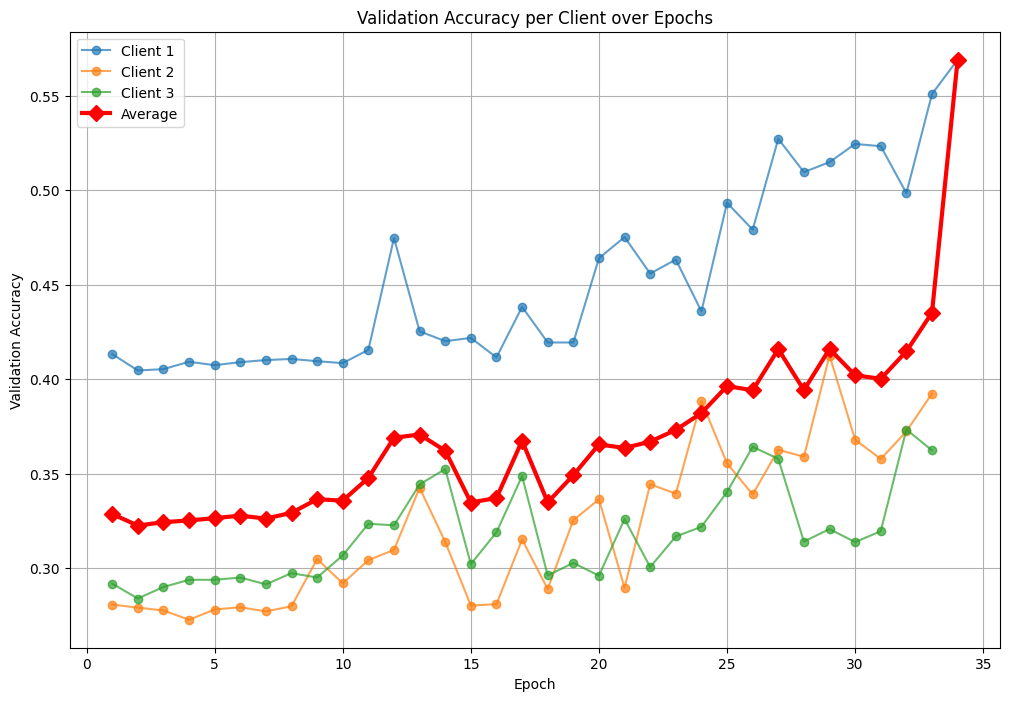

In [169]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_log_file_cyclic_clients(filepath, num_clients=3):
    # Regex to extract acc from validation lines
    pattern = re.compile(r"phase=validation acc=([\d\.]+)")
    
    validation_accuracies = []
    
    with open(filepath, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                acc = float(match.group(1))
                validation_accuracies.append(acc)
    
    print(f"Total validation accuracies found: {len(validation_accuracies)}")
    
    # Group accuracies by epoch (every num_clients accuracies = 1 epoch)
    accuracies = {}
    
    for i in range(0, len(validation_accuracies), num_clients):
        epoch = (i // num_clients) + 1  # Epochs start from 1
        accuracies[epoch] = {}
        
        # Assign accuracies to clients for this epoch
        for client_id in range(1, num_clients + 1):
            acc_index = i + (client_id - 1)
            if acc_index < len(validation_accuracies):
                accuracies[epoch][client_id] = validation_accuracies[acc_index]
            else:
                accuracies[epoch][client_id] = None
    
    print(f"Parsed {len(accuracies)} epochs")
    print(f"First epoch data: {accuracies.get(1, {})}")
    
    return accuracies

def plot_accuracies(accuracies, num_clients=3):
    epochs = sorted(accuracies.keys())
    
    plt.figure(figsize=(12,8))
    
    # Plot individual client lines
    for cid in range(1, num_clients+1):
        client_epochs = []
        client_accs = []
        
        for epoch in epochs:
            acc = accuracies[epoch].get(cid, None)
            if acc is not None:
                client_epochs.append(epoch)
                client_accs.append(acc)
        
        plt.plot(client_epochs, client_accs, marker='o', label=f'Client {cid}', alpha=0.7)
    
    # Calculate average accuracy for each epoch
    avg_epochs = []
    avg_accs = []
    
    for epoch in epochs:
        # Get accuracies for all 3 clients at this epoch
        client_accs = []
        for cid in range(1, num_clients+1):
            acc = accuracies[epoch].get(cid, None)
            if acc is not None:
                client_accs.append(acc)
        
        # Calculate average if we have at least one client
        if client_accs:
            avg_epochs.append(epoch)
            avg_accs.append(sum(client_accs) / len(client_accs))
    
    # Plot average line
    plt.plot(avg_epochs, avg_accs, marker='D', linewidth=3, color='red', 
             label='Average', alpha=1.0, markersize=8)
    
    print(f"Average line has {len(avg_epochs)} points")
    
    plt.title('Validation Accuracy per Client over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    log_file_path = "log_dataminstvanilla_noniid0.3-epoch100.txt"  # Replace with your log file path
    num_clients = 3
    
    accuracies = parse_log_file_cyclic_clients(log_file_path, num_clients)
    plot_accuracies(accuracies, num_clients)

Total validation accuracies found: 299
Parsed 100 epochs
First epoch data: {1: 0.10346554487179487, 2: 0.10356570512820513, 3: 0.10496794871794872}
Average line has 100 points


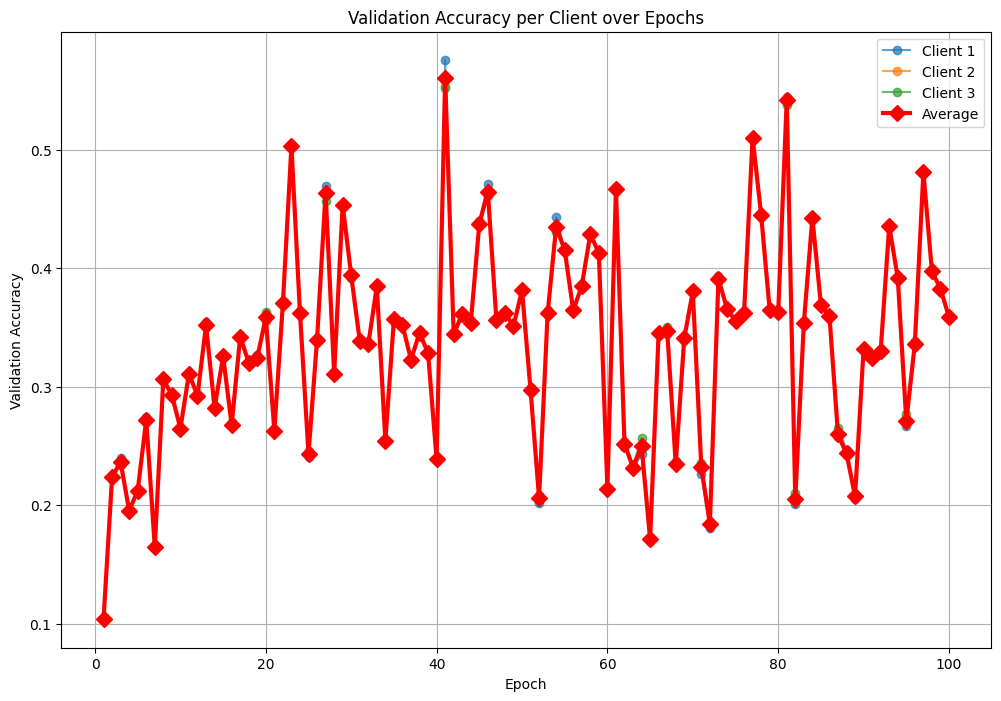

In [182]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_log_file_cyclic_clients(filepath, num_clients=3):
    # Regex to extract acc from validation lines
    pattern = re.compile(r"phase=validation acc=([\d\.]+)")
    
    validation_accuracies = []
    
    with open(filepath, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                acc = float(match.group(1))
                validation_accuracies.append(acc)
    
    print(f"Total validation accuracies found: {len(validation_accuracies)}")
    
    # Group accuracies by epoch (every num_clients accuracies = 1 epoch)
    accuracies = {}
    
    for i in range(0, len(validation_accuracies), num_clients):
        epoch = (i // num_clients) + 1  # Epochs start from 1
        accuracies[epoch] = {}
        
        # Assign accuracies to clients for this epoch
        for client_id in range(1, num_clients + 1):
            acc_index = i + (client_id - 1)
            if acc_index < len(validation_accuracies):
                accuracies[epoch][client_id] = validation_accuracies[acc_index]
            else:
                accuracies[epoch][client_id] = None
    
    print(f"Parsed {len(accuracies)} epochs")
    print(f"First epoch data: {accuracies.get(1, {})}")
    
    return accuracies

def plot_accuracies(accuracies, num_clients=3):
    epochs = sorted(accuracies.keys())
    
    plt.figure(figsize=(12,8))
    
    # Plot individual client lines
    for cid in range(1, num_clients+1):
        client_epochs = []
        client_accs = []
        
        for epoch in epochs:
            acc = accuracies[epoch].get(cid, None)
            if acc is not None:
                client_epochs.append(epoch)
                client_accs.append(acc)
        
        plt.plot(client_epochs, client_accs, marker='o', label=f'Client {cid}', alpha=0.7)
    
    # Calculate average accuracy for each epoch
    avg_epochs = []
    avg_accs = []
    
    for epoch in epochs:
        # Get accuracies for all 3 clients at this epoch
        client_accs = []
        for cid in range(1, num_clients+1):
            acc = accuracies[epoch].get(cid, None)
            if acc is not None:
                client_accs.append(acc)
        
        # Calculate average if we have at least one client
        if client_accs:
            avg_epochs.append(epoch)
            avg_accs.append(sum(client_accs) / len(client_accs))
    
    # Plot average line
    plt.plot(avg_epochs, avg_accs, marker='D', linewidth=3, color='red', 
             label='Average', alpha=1.0, markersize=8)
    
    print(f"Average line has {len(avg_epochs)} points")
    
    plt.title('Validation Accuracy per Client over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    log_file_path = "log_psl_3clientnoniid0.3_splitfed02.txt"  # Replace with your log file path
    num_clients = 3
    
    
    accuracies = parse_log_file_cyclic_clients(log_file_path, num_clients)
    plot_accuracies(accuracies, num_clients)

Total validation accuracies found: 299
Parsed 100 epochs
First epoch data: {1: 0.10346554487179487, 2: 0.10356570512820513, 3: 0.10496794871794872}
Average line has 100 points


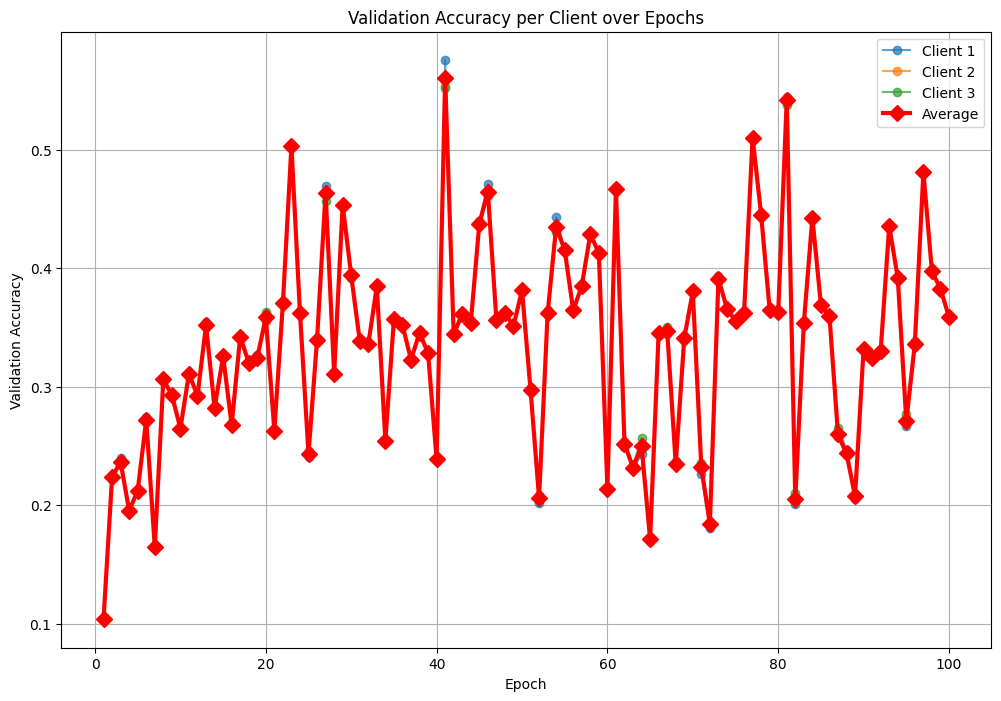

In [185]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_log_file_cyclic_clients(filepath, num_clients=3):
    # Regex to extract acc from validation lines
    pattern = re.compile(r"phase=validation acc=([\d\.]+)")
    
    validation_accuracies = []
    
    with open(filepath, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                acc = float(match.group(1))
                validation_accuracies.append(acc)
    
    print(f"Total validation accuracies found: {len(validation_accuracies)}")
    
    # Group accuracies by epoch (every num_clients accuracies = 1 epoch)
    accuracies = {}
    
    for i in range(0, len(validation_accuracies), num_clients):
        epoch = (i // num_clients) + 1  # Epochs start from 1
        accuracies[epoch] = {}
        
        # Assign accuracies to clients for this epoch
        for client_id in range(1, num_clients + 1):
            acc_index = i + (client_id - 1)
            if acc_index < len(validation_accuracies):
                accuracies[epoch][client_id] = validation_accuracies[acc_index]
            else:
                accuracies[epoch][client_id] = None
    
    print(f"Parsed {len(accuracies)} epochs")
    print(f"First epoch data: {accuracies.get(1, {})}")
    
    return accuracies

def plot_accuracies(accuracies, num_clients=3):
    epochs = sorted(accuracies.keys())
    
    plt.figure(figsize=(12,8))
    
    # Plot individual client lines
    for cid in range(1, num_clients+1):
        client_epochs = []
        client_accs = []
        
        for epoch in epochs:
            acc = accuracies[epoch].get(cid, None)
            if acc is not None:
                client_epochs.append(epoch)
                client_accs.append(acc)
        
        plt.plot(client_epochs, client_accs, marker='o', label=f'Client {cid}', alpha=0.7)
    
    # Calculate average accuracy for each epoch
    avg_epochs = []
    avg_accs = []
    
    for epoch in epochs:
        # Get accuracies for all 3 clients at this epoch
        client_accs = []
        for cid in range(1, num_clients+1):
            acc = accuracies[epoch].get(cid, None)
            if acc is not None:
                client_accs.append(acc)
        
        # Calculate average if we have at least one client
        if client_accs:
            avg_epochs.append(epoch)
            avg_accs.append(sum(client_accs) / len(client_accs))
    
    # Plot average line
    plt.plot(avg_epochs, avg_accs, marker='D', linewidth=3, color='red', 
             label='Average', alpha=1.0, markersize=8)
    
    print(f"Average line has {len(avg_epochs)} points")
    
    plt.title('Validation Accuracy per Client over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    log_file_path = "log_psl_3clientnoniid0.3_splitfed02.txt"  # Replace with your log file path
    num_clients = 3
    
    accuracies = parse_log_file_cyclic_clients(log_file_path, num_clients)
    plot_accuracies(accuracies, num_clients)

In [186]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_splitnn_logs(log_content):
    """
    Parse SplitNN logs to extract validation accuracies for each client by epoch
    """
    # Dictionary to store validation accuracies by epoch and client
    validation_data = defaultdict(dict)
    
    # Regular expression to match validation log lines
    validation_pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}),\d+ - SplitNNClient - INFO - (\d+) - phase=validation acc=([\d.]+) loss=([\d.]+) epoch=(\d+)'
    
    # Find all validation entries
    validation_matches = re.findall(validation_pattern, log_content)
    
    # Group by epoch and sort by timestamp to maintain client order
    epoch_validations = defaultdict(list)
    
    for timestamp, worker_id, acc, loss, epoch in validation_matches:
        epoch_validations[int(epoch)].append({
            'timestamp': timestamp,
            'worker_id': worker_id,
            'accuracy': float(acc),
            'loss': float(loss)
        })
    
    # Sort each epoch's validations by timestamp to maintain client order
    for epoch in epoch_validations:
        epoch_validations[epoch].sort(key=lambda x: x['timestamp'])
        
        # Assign to clients (Client1, Client2, Client3)
        for i, validation in enumerate(epoch_validations[epoch]):
            client_name = f'Client{i+1}'
            validation_data[epoch][client_name] = validation['accuracy']
    
    return validation_data

def create_accuracy_dataframe(validation_data):
    """
    Create a pandas DataFrame from validation data
    """
    # Convert to DataFrame
    df = pd.DataFrame.from_dict(validation_data, orient='index')
    df.index.name = 'Epoch'
    df = df.sort_index()
    
    return df

def plot_client_accuracies(df):
    """
    Plot validation accuracies for each client across epochs
    """
    plt.figure(figsize=(12, 8))
    
    # Plot each client's accuracy
    for client in df.columns:
        if client in df.columns:
            plt.plot(df.index, df[client], marker='o', linewidth=2, label=client)
    
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy by Client Across Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def print_summary_stats(df):
    """
    Print summary statistics for each client
    """
    print("\n=== CLIENT VALIDATION ACCURACY SUMMARY ===")
    print(f"{'Client':<10} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
    print("-" * 50)
    
    for client in df.columns:
        if client in df.columns:
            mean_acc = df[client].mean()
            std_acc = df[client].std()
            min_acc = df[client].min()
            max_acc = df[client].max()
            print(f"{client:<10} {mean_acc:.4f}    {std_acc:.4f}    {min_acc:.4f}    {max_acc:.4f}")

def read_log_file(filename="log.txt"):
    """
    Read log file and return content
    """
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            return f.read()
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found!")
        print("Please make sure the log file exists in the current directory.")
        return None
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

if __name__ == "__main__":
    # Read log file
    print("Reading log file...")
    log_content = read_log_file("log.txt")
    
    if log_content is None:
        exit(1)
    
    print(f"Log file loaded successfully! ({len(log_content)} characters)")
    
    # Parse the logs
    print("Parsing validation data...")
    validation_data = parse_splitnn_logs(log_content)
    
    if not validation_data:
        print("No validation data found in the log file!")
        exit(1)
    
    # Create DataFrame
    df = create_accuracy_dataframe(validation_data)
    
    print(f"Found validation data for {len(df)} epochs")
    print(f"Clients detected: {list(df.columns)}")
    
    # Display results
    print("\n=== VALIDATION ACCURACIES BY EPOCH AND CLIENT ===")
    print(df.round(4))
    
    # Print summary statistics
    print_summary_stats(df)
    
    # Save results to CSV
    output_file = "log_psl_3clientnoniid0.3_splitfed02.txt"
    df.to_csv(output_file)
    print(f"\nResults saved to: {output_file}")
    
    # Plot the results
    print("Generating plot...")
    plot_client_accuracies(df)
    
    # Show some specific examples if data exists
    if len(df) > 0:
        latest_epoch = df.index.max()
        print(f"\nLatest epoch ({latest_epoch}) accuracies:")
        for client in df.columns:
            if client in df.columns:
                acc = df.loc[latest_epoch, client]
                print(f"  {client}: {acc:.4f}")
    
    print("\nAnalysis complete!")

Reading log file...
Error: File 'log.txt' not found!
Please make sure the log file exists in the current directory.


TypeError: object of type 'NoneType' has no len()

Reading log file: log_psl_3clientsnonIID.txt
Log file loaded successfully! (152126 characters)
Parsing validation data...
Found validation data for 50 epochs
Clients detected: ['Client1', 'Client2', 'Client3']
Epoch range: 0 to 49

=== VALIDATION ACCURACIES BY EPOCH AND CLIENT ===
       Client1  Client2  Client3
Epoch                           
0       0.0904   0.1339   0.1503
1       0.1001   0.1119   0.1816
2       0.1319   0.1141   0.1931
3       0.0773   0.1352   0.1570
4       0.1196   0.1029   0.1874
5       0.1265   0.1411   0.2067
6       0.1185   0.1400   0.1738
7       0.1076   0.2155   0.1160
8       0.0636   0.1484   0.1253
9       0.1032   0.1144   0.2040
10      0.0939   0.1452   0.1936
11      0.1182   0.1625   0.1854
12      0.1002   0.1310   0.2038
13      0.1036   0.1328   0.2220
14      0.1112   0.1873   0.1239
15      0.1206   0.2199   0.1290
16      0.1140   0.1545   0.2226
17      0.1153   0.1733   0.2118
18      0.1321   0.1244   0.2259
19      0.1119   0.1387  

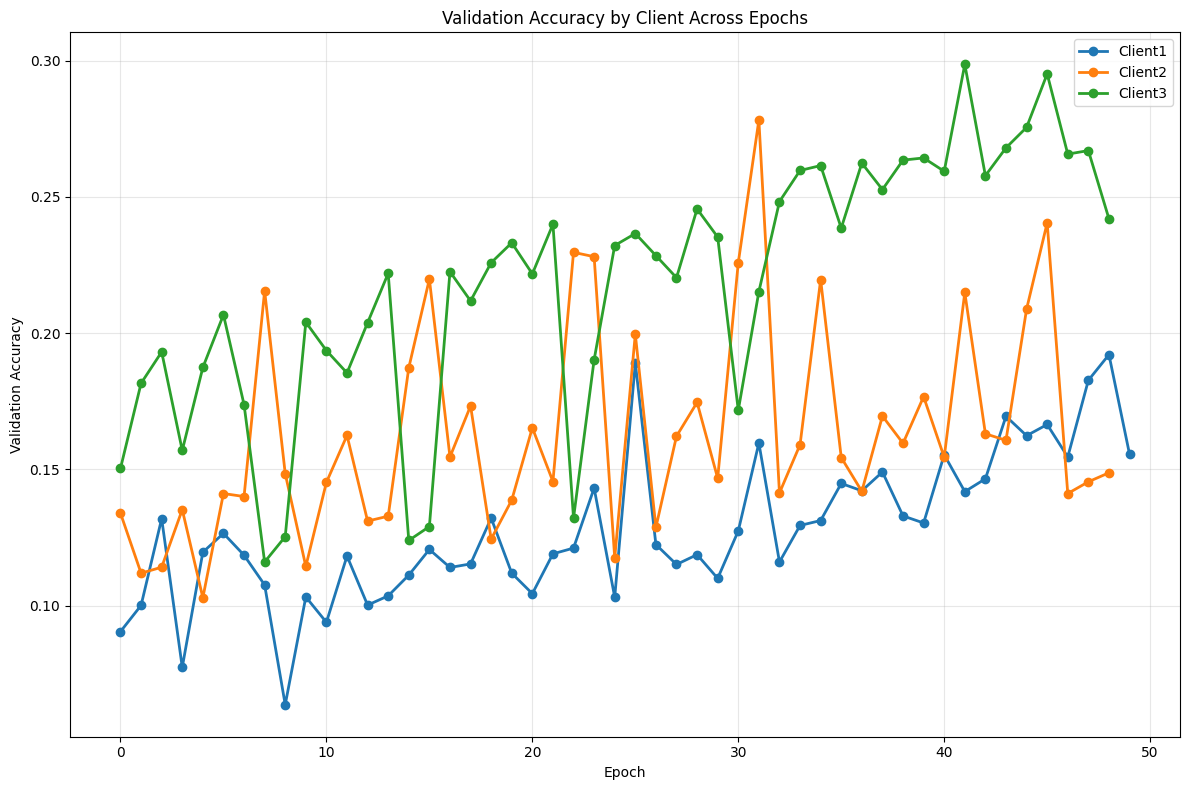


Earliest epoch (0) accuracies:
  Client1: 0.0904
  Client2: 0.1339
  Client3: 0.1503

Latest epoch (49) accuracies:
  Client1: 0.1555
  Client2: nan
  Client3: nan

Accuracy improvement from epoch 0 to 49:
  Client1: +0.0651 (+6.51%)
  Client2: +nan (+nan%)
  Client3: +nan (+nan%)

Analysis complete!
Non-IID setting: 3 clients with 0.3 non-IID factor
Method: SplitFed
Results saved to: client_validation_accuracies_splitfed.csv


In [188]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_splitnn_logs(log_content):
    """
    Parse SplitNN logs to extract validation accuracies for each client by epoch
    """
    # Dictionary to store validation accuracies by epoch and client
    validation_data = defaultdict(dict)
    
    # Regular expression to match validation log lines
    validation_pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}),\d+ - SplitNNClient - INFO - (\d+) - phase=validation acc=([\d.]+) loss=([\d.]+) epoch=(\d+)'
    
    # Find all validation entries
    validation_matches = re.findall(validation_pattern, log_content)
    
    # Group by epoch and sort by timestamp to maintain client order
    epoch_validations = defaultdict(list)
    
    for timestamp, worker_id, acc, loss, epoch in validation_matches:
        epoch_validations[int(epoch)].append({
            'timestamp': timestamp,
            'worker_id': worker_id,
            'accuracy': float(acc),
            'loss': float(loss)
        })
    
    # Sort each epoch's validations by timestamp to maintain client order
    for epoch in epoch_validations:
        epoch_validations[epoch].sort(key=lambda x: x['timestamp'])
        
        # Assign to clients (Client1, Client2, Client3)
        for i, validation in enumerate(epoch_validations[epoch]):
            client_name = f'Client{i+1}'
            validation_data[epoch][client_name] = validation['accuracy']
    
    return validation_data

def create_accuracy_dataframe(validation_data):
    """
    Create a pandas DataFrame from validation data
    """
    # Convert to DataFrame
    df = pd.DataFrame.from_dict(validation_data, orient='index')
    df.index.name = 'Epoch'
    df = df.sort_index()
    
    return df

def plot_client_accuracies(df):
    """
    Plot validation accuracies for each client across epochs
    """
    plt.figure(figsize=(12, 8))
    
    # Plot each client's accuracy
    for client in df.columns:
        if client in df.columns:
            plt.plot(df.index, df[client], marker='o', linewidth=2, label=client)
    
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy by Client Across Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def print_summary_stats(df):
    """
    Print summary statistics for each client
    """
    print("\n=== CLIENT VALIDATION ACCURACY SUMMARY ===")
    print(f"{'Client':<10} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
    print("-" * 50)
    
    for client in df.columns:
        if client in df.columns:
            mean_acc = df[client].mean()
            std_acc = df[client].std()
            min_acc = df[client].min()
            max_acc = df[client].max()
            print(f"{client:<10} {mean_acc:.4f}    {std_acc:.4f}    {min_acc:.4f}    {max_acc:.4f}")

def read_log_file(filename="log_psl_3clientnoniid0.3_splitfed02.txt"):
    """
    Read log file and return content
    """
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            return f.read()
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found!")
        print("Please make sure the log file exists in the current directory.")
        return None
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

if __name__ == "__main__":
    # Read log file
    filename = "log_psl_3clientsnonIID.txt"
    print(f"Reading log file: {filename}")
    log_content = read_log_file(filename)
    
    if log_content is None:
        print(f"Please ensure '{filename}' exists in the current directory.")
        exit(1)
    
    print(f"Log file loaded successfully! ({len(log_content)} characters)")
    
    # Parse the logs
    print("Parsing validation data...")
    validation_data = parse_splitnn_logs(log_content)
    
    if not validation_data:
        print("No validation data found in the log file!")
        print("Make sure the log contains lines with 'phase=validation' entries.")
        exit(1)
    
    # Create DataFrame
    df = create_accuracy_dataframe(validation_data)
    
    print(f"Found validation data for {len(df)} epochs")
    print(f"Clients detected: {list(df.columns)}")
    print(f"Epoch range: {df.index.min()} to {df.index.max()}")
    
    # Display results
    print("\n=== VALIDATION ACCURACIES BY EPOCH AND CLIENT ===")
    print(df.round(4))
    
    # Print summary statistics
    print_summary_stats(df)
    
    # Save results to CSV
    output_file = "client_validation_accuracies_splitfed.csv"
    df.to_csv(output_file)
    print(f"\nResults saved to: {output_file}")
    
    # Plot the results
    print("Generating plot...")
    plot_client_accuracies(df)
    
    # Show some specific examples if data exists
    if len(df) > 0:
        latest_epoch = df.index.max()
        earliest_epoch = df.index.min()
        
        print(f"\nEarliest epoch ({earliest_epoch}) accuracies:")
        for client in df.columns:
            if client in df.columns:
                acc = df.loc[earliest_epoch, client]
                print(f"  {client}: {acc:.4f}")
        
        print(f"\nLatest epoch ({latest_epoch}) accuracies:")
        for client in df.columns:
            if client in df.columns:
                acc = df.loc[latest_epoch, client]
                print(f"  {client}: {acc:.4f}")
        
        # Show improvement
        print(f"\nAccuracy improvement from epoch {earliest_epoch} to {latest_epoch}:")
        for client in df.columns:
            if client in df.columns:
                early_acc = df.loc[earliest_epoch, client]
                late_acc = df.loc[latest_epoch, client]
                improvement = late_acc - early_acc
                print(f"  {client}: {improvement:+.4f} ({improvement*100:+.2f}%)")
    
    print("\nAnalysis complete!")
    print(f"Non-IID setting: 3 clients with 0.3 non-IID factor")
    print(f"Method: SplitFed")
    print(f"Results saved to: {output_file}")

Reading log file: log_psl_3client.txt
Log file loaded successfully! (126399 characters)
Parsing validation data...
Found validation data for 50 epochs
Clients detected: ['Client1', 'Client2', 'Client3', 'Average']
Epoch range: 0 to 49

=== VALIDATION ACCURACIES BY EPOCH AND CLIENT ===
       Client1  Client2  Client3  Average
Epoch                                    
0       0.0982   0.1542   0.1773   0.1432
1       0.1574   0.1489   0.1853   0.1639
2       0.2207   0.1915   0.1357   0.1826
3       0.1338   0.1171   0.1895   0.1468
4       0.1561   0.1532   0.1860   0.1651
5       0.1382   0.1663   0.1792   0.1612
6       0.1913   0.1288   0.1972   0.1724
7       0.1959   0.1564   0.1419   0.1647
8       0.1865   0.1947   0.2099   0.1970
9       0.1680   0.1570   0.2157   0.1802
10      0.2192   0.2027   0.1403   0.1874
11      0.2136   0.1395   0.2013   0.1848
12      0.2002   0.1776   0.1402   0.1727
13      0.1712   0.1241   0.1839   0.1597
14      0.1863   0.1259   0.2047   0.1723


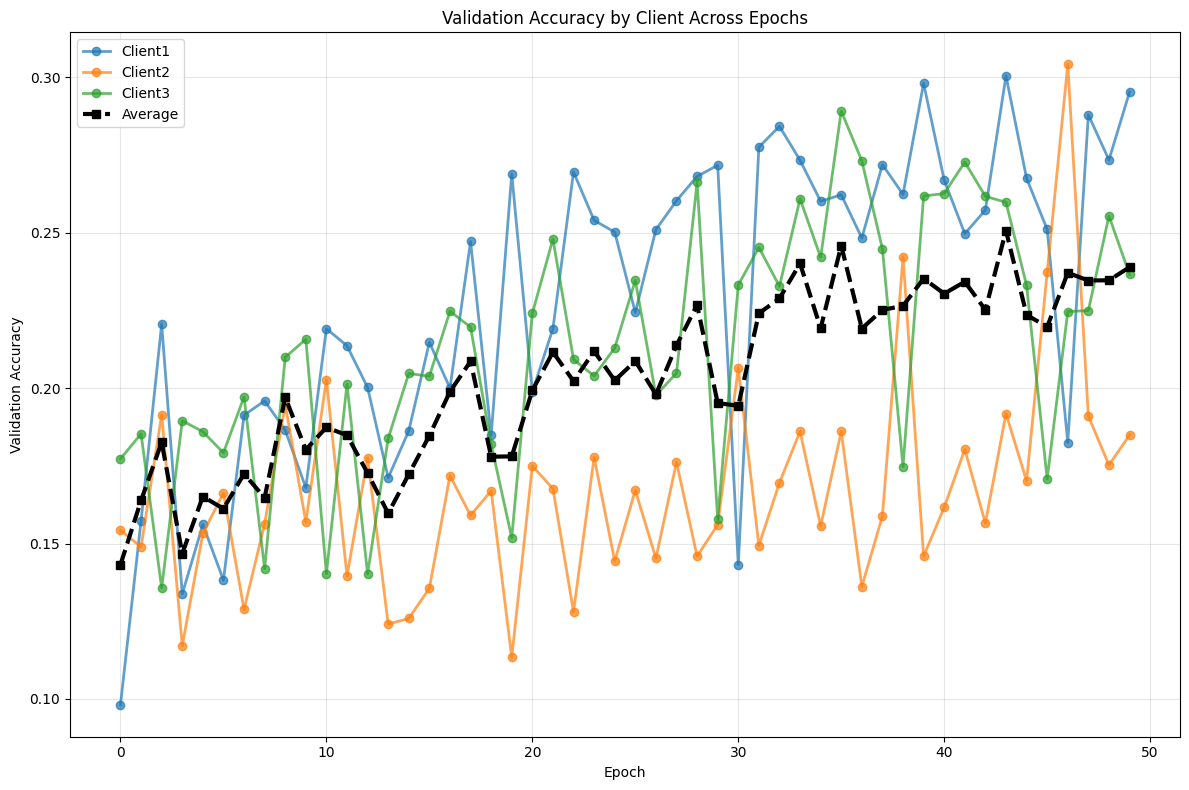


Earliest epoch (0) accuracies:
  Client1: 0.0982
  Client2: 0.1542
  Client3: 0.1773
  Average: 0.1432

Latest epoch (49) accuracies:
  Client1: 0.2953
  Client2: 0.1849
  Client3: 0.2366
  Average: 0.2389

Accuracy improvement from epoch 0 to 49:
  Client1: +0.1971 (+19.71%)
  Client2: +0.0306 (+3.06%)
  Client3: +0.0593 (+5.93%)
  Average: +0.0957 (+9.57%)

Analysis complete!
Non-IID setting: 3 clients with 0.3 non-IID factor
Method: SplitFed
Results saved to: client_validation_accuracies_splitfed.csv


In [190]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_splitnn_logs(log_content):
    """
    Parse SplitNN logs to extract validation accuracies for each client by epoch
    """
    # Dictionary to store validation accuracies by epoch and client
    validation_data = defaultdict(dict)
    
    # Regular expression to match validation log lines
    validation_pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}),\d+ - SplitNNClient - INFO - (\d+) - phase=validation acc=([\d.]+) loss=([\d.]+) epoch=(\d+)'
    
    # Find all validation entries
    validation_matches = re.findall(validation_pattern, log_content)
    
    # Group by epoch and sort by timestamp to maintain client order
    epoch_validations = defaultdict(list)
    
    for timestamp, worker_id, acc, loss, epoch in validation_matches:
        epoch_validations[int(epoch)].append({
            'timestamp': timestamp,
            'worker_id': worker_id,
            'accuracy': float(acc),
            'loss': float(loss)
        })
    
    # Sort each epoch's validations by timestamp to maintain client order
    for epoch in epoch_validations:
        epoch_validations[epoch].sort(key=lambda x: x['timestamp'])
        
        # Assign to clients (Client1, Client2, Client3)
        for i, validation in enumerate(epoch_validations[epoch]):
            client_name = f'Client{i+1}'
            validation_data[epoch][client_name] = validation['accuracy']
    
    return validation_data

def create_accuracy_dataframe(validation_data):
    """
    Create a pandas DataFrame from validation data
    """
    # Convert to DataFrame
    df = pd.DataFrame.from_dict(validation_data, orient='index')
    df.index.name = 'Epoch'
    df = df.sort_index()
    
    # Add average column
    df['Average'] = df.mean(axis=1)
    
    return df

def plot_client_accuracies(df):
    """
    Plot validation accuracies for each client across epochs
    """
    plt.figure(figsize=(12, 8))
    
    # Plot each client's accuracy
    client_columns = [col for col in df.columns if col.startswith('Client')]
    for client in client_columns:
        plt.plot(df.index, df[client], marker='o', linewidth=2, label=client, alpha=0.7)
    
    # Plot average with different style
    if 'Average' in df.columns:
        plt.plot(df.index, df['Average'], marker='s', linewidth=3, 
                label='Average', color='black', linestyle='--')
    
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy by Client Across Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def print_summary_stats(df):
    """
    Print summary statistics for each client and average
    """
    print("\n=== CLIENT VALIDATION ACCURACY SUMMARY ===")
    print(f"{'Client':<10} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
    print("-" * 50)
    
    # Individual clients
    client_columns = [col for col in df.columns if col.startswith('Client')]
    for client in client_columns:
        mean_acc = df[client].mean()
        std_acc = df[client].std()
        min_acc = df[client].min()
        max_acc = df[client].max()
        print(f"{client:<10} {mean_acc:.4f}    {std_acc:.4f}    {min_acc:.4f}    {max_acc:.4f}")
    
    # Average across clients
    if 'Average' in df.columns:
        print("-" * 50)
        mean_acc = df['Average'].mean()
        std_acc = df['Average'].std()
        min_acc = df['Average'].min()
        max_acc = df['Average'].max()
        print(f"{'Average':<10} {mean_acc:.4f}    {std_acc:.4f}    {min_acc:.4f}    {max_acc:.4f}")

def read_log_file(filename="log_psl_3clientnoniid0.3_splitfed02.txt"):
    """
    Read log file and return content
    """
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            return f.read()
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found!")
        print("Please make sure the log file exists in the current directory.")
        return None
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

if __name__ == "__main__":
    # Read log file
    filename = "log_psl_3client.txt"
    print(f"Reading log file: {filename}")
    log_content = read_log_file(filename)
    
    if log_content is None:
        print(f"Please ensure '{filename}' exists in the current directory.")
        exit(1)
    
    print(f"Log file loaded successfully! ({len(log_content)} characters)")
    
    # Parse the logs
    print("Parsing validation data...")
    validation_data = parse_splitnn_logs(log_content)
    
    if not validation_data:
        print("No validation data found in the log file!")
        print("Make sure the log contains lines with 'phase=validation' entries.")
        exit(1)
    
    # Create DataFrame
    df = create_accuracy_dataframe(validation_data)
    
    print(f"Found validation data for {len(df)} epochs")
    print(f"Clients detected: {list(df.columns)}")
    print(f"Epoch range: {df.index.min()} to {df.index.max()}")
    
    # Display results
    print("\n=== VALIDATION ACCURACIES BY EPOCH AND CLIENT ===")
    print(df.round(4))
    
    # Print summary statistics
    print_summary_stats(df)
    
    # Save results to CSV
    output_file = "client_validation_accuracies_splitfed.csv"
    df.to_csv(output_file)
    print(f"\nResults saved to: {output_file}")
    
    # Plot the results
    print("Generating plot...")
    plot_client_accuracies(df)
    
    # Show some specific examples if data exists
    if len(df) > 0:
        latest_epoch = df.index.max()
        earliest_epoch = df.index.min()
        
        print(f"\nEarliest epoch ({earliest_epoch}) accuracies:")
        client_columns = [col for col in df.columns if col.startswith('Client')]
        for client in client_columns:
            acc = df.loc[earliest_epoch, client]
            print(f"  {client}: {acc:.4f}")
        if 'Average' in df.columns:
            avg_acc = df.loc[earliest_epoch, 'Average']
            print(f"  Average: {avg_acc:.4f}")
        
        print(f"\nLatest epoch ({latest_epoch}) accuracies:")
        for client in client_columns:
            acc = df.loc[latest_epoch, client]
            print(f"  {client}: {acc:.4f}")
        if 'Average' in df.columns:
            avg_acc = df.loc[latest_epoch, 'Average']
            print(f"  Average: {avg_acc:.4f}")
        
        # Show improvement
        print(f"\nAccuracy improvement from epoch {earliest_epoch} to {latest_epoch}:")
        for client in client_columns:
            early_acc = df.loc[earliest_epoch, client]
            late_acc = df.loc[latest_epoch, client]
            improvement = late_acc - early_acc
            print(f"  {client}: {improvement:+.4f} ({improvement*100:+.2f}%)")
        
        if 'Average' in df.columns:
            early_avg = df.loc[earliest_epoch, 'Average']
            late_avg = df.loc[latest_epoch, 'Average']
            avg_improvement = late_avg - early_avg
            print(f"  Average: {avg_improvement:+.4f} ({avg_improvement*100:+.2f}%)")
    
    print("\nAnalysis complete!")
    print(f"Non-IID setting: 3 clients with 0.3 non-IID factor")
    print(f"Method: SplitFed")
    print(f"Results saved to: {output_file}")

Reading log file: log_psl_3clientsnonIID.txt
Log file loaded successfully! (152126 characters)
Parsing validation data...
Found validation data for 50 epochs
Clients detected: ['Client1', 'Client2', 'Client3', 'Average']
Epoch range: 0 to 49

=== VALIDATION ACCURACIES BY EPOCH AND CLIENT ===
       Client1  Client2  Client3  Average
Epoch                                    
0       0.0904   0.1339   0.1503   0.1249
1       0.1001   0.1119   0.1816   0.1312
2       0.1319   0.1141   0.1931   0.1464
3       0.0773   0.1352   0.1570   0.1232
4       0.1196   0.1029   0.1874   0.1366
5       0.1265   0.1411   0.2067   0.1581
6       0.1185   0.1400   0.1738   0.1441
7       0.1076   0.2155   0.1160   0.1464
8       0.0636   0.1484   0.1253   0.1124
9       0.1032   0.1144   0.2040   0.1405
10      0.0939   0.1452   0.1936   0.1442
11      0.1182   0.1625   0.1854   0.1553
12      0.1002   0.1310   0.2038   0.1450
13      0.1036   0.1328   0.2220   0.1528
14      0.1112   0.1873   0.1239   

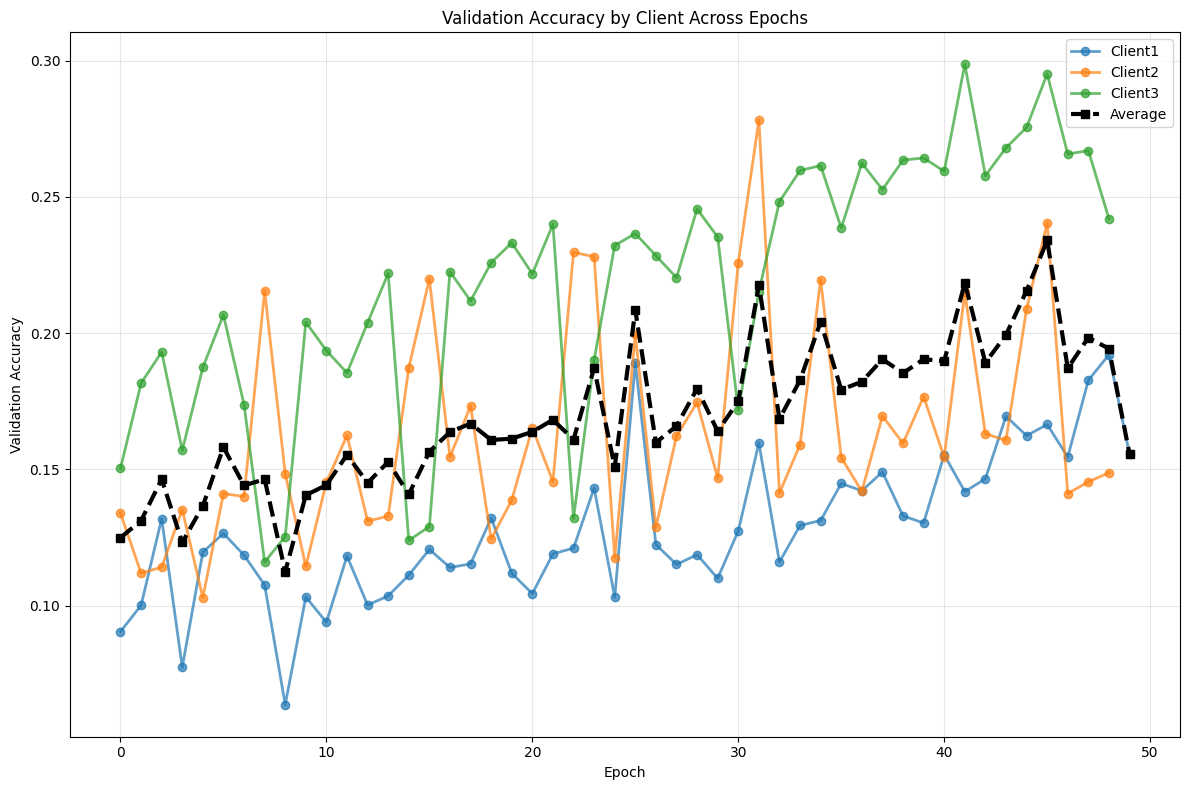


Earliest epoch (0) accuracies:
  Client1: 0.0904
  Client2: 0.1339
  Client3: 0.1503
  Average: 0.1249

Latest epoch (49) accuracies:
  Client1: 0.1555
  Client2: nan
  Client3: nan
  Average: 0.1555

Accuracy improvement from epoch 0 to 49:
  Client1: +0.0651 (+6.51%)
  Client2: +nan (+nan%)
  Client3: +nan (+nan%)
  Average: +0.0306 (+3.06%)

Analysis complete!
Non-IID setting: 3 clients with 0.3 non-IID factor
Method: SplitFed
Results saved to: client_validation_accuracies_splitfed.csv


In [191]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_splitnn_logs(log_content):
    """
    Parse SplitNN logs to extract validation accuracies for each client by epoch
    """
    # Dictionary to store validation accuracies by epoch and client
    validation_data = defaultdict(dict)
    
    # Regular expression to match validation log lines
    validation_pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}),\d+ - SplitNNClient - INFO - (\d+) - phase=validation acc=([\d.]+) loss=([\d.]+) epoch=(\d+)'
    
    # Find all validation entries
    validation_matches = re.findall(validation_pattern, log_content)
    
    # Group by epoch and sort by timestamp to maintain client order
    epoch_validations = defaultdict(list)
    
    for timestamp, worker_id, acc, loss, epoch in validation_matches:
        epoch_validations[int(epoch)].append({
            'timestamp': timestamp,
            'worker_id': worker_id,
            'accuracy': float(acc),
            'loss': float(loss)
        })
    
    # Sort each epoch's validations by timestamp to maintain client order
    for epoch in epoch_validations:
        epoch_validations[epoch].sort(key=lambda x: x['timestamp'])
        
        # Assign to clients (Client1, Client2, Client3)
        for i, validation in enumerate(epoch_validations[epoch]):
            client_name = f'Client{i+1}'
            validation_data[epoch][client_name] = validation['accuracy']
    
    return validation_data

def create_accuracy_dataframe(validation_data):
    """
    Create a pandas DataFrame from validation data
    """
    # Convert to DataFrame
    df = pd.DataFrame.from_dict(validation_data, orient='index')
    df.index.name = 'Epoch'
    df = df.sort_index()
    
    # Add average column
    df['Average'] = df.mean(axis=1)
    
    return df

def plot_client_accuracies(df):
    """
    Plot validation accuracies for each client across epochs
    """
    plt.figure(figsize=(12, 8))
    
    # Plot each client's accuracy
    client_columns = [col for col in df.columns if col.startswith('Client')]
    for client in client_columns:
        plt.plot(df.index, df[client], marker='o', linewidth=2, label=client, alpha=0.7)
    
    # Plot average with different style
    if 'Average' in df.columns:
        plt.plot(df.index, df['Average'], marker='s', linewidth=3, 
                label='Average', color='black', linestyle='--')
    
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy by Client Across Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def print_summary_stats(df):
    """
    Print summary statistics for each client and average
    """
    print("\n=== CLIENT VALIDATION ACCURACY SUMMARY ===")
    print(f"{'Client':<10} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
    print("-" * 50)
    
    # Individual clients
    client_columns = [col for col in df.columns if col.startswith('Client')]
    for client in client_columns:
        mean_acc = df[client].mean()
        std_acc = df[client].std()
        min_acc = df[client].min()
        max_acc = df[client].max()
        print(f"{client:<10} {mean_acc:.4f}    {std_acc:.4f}    {min_acc:.4f}    {max_acc:.4f}")
    
    # Average across clients
    if 'Average' in df.columns:
        print("-" * 50)
        mean_acc = df['Average'].mean()
        std_acc = df['Average'].std()
        min_acc = df['Average'].min()
        max_acc = df['Average'].max()
        print(f"{'Average':<10} {mean_acc:.4f}    {std_acc:.4f}    {min_acc:.4f}    {max_acc:.4f}")

def read_log_file(filename="log_psl_3clientnoniid0.3_splitfed02.txt"):
    """
    Read log file and return content
    """
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            return f.read()
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found!")
        print("Please make sure the log file exists in the current directory.")
        return None
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

if __name__ == "__main__":
    # Read log file
    filename = "log_psl_3clientsnonIID.txt"
    print(f"Reading log file: {filename}")
    log_content = read_log_file(filename)
    
    if log_content is None:
        print(f"Please ensure '{filename}' exists in the current directory.")
        exit(1)
    
    print(f"Log file loaded successfully! ({len(log_content)} characters)")
    
    # Parse the logs
    print("Parsing validation data...")
    validation_data = parse_splitnn_logs(log_content)
    
    if not validation_data:
        print("No validation data found in the log file!")
        print("Make sure the log contains lines with 'phase=validation' entries.")
        exit(1)
    
    # Create DataFrame
    df = create_accuracy_dataframe(validation_data)
    
    print(f"Found validation data for {len(df)} epochs")
    print(f"Clients detected: {list(df.columns)}")
    print(f"Epoch range: {df.index.min()} to {df.index.max()}")
    
    # Display results
    print("\n=== VALIDATION ACCURACIES BY EPOCH AND CLIENT ===")
    print(df.round(4))
    
    # Print summary statistics
    print_summary_stats(df)
    
    # Save results to CSV
    output_file = "client_validation_accuracies_splitfed.csv"
    df.to_csv(output_file)
    print(f"\nResults saved to: {output_file}")
    
    # Plot the results
    print("Generating plot...")
    plot_client_accuracies(df)
    
    # Show some specific examples if data exists
    if len(df) > 0:
        latest_epoch = df.index.max()
        earliest_epoch = df.index.min()
        
        print(f"\nEarliest epoch ({earliest_epoch}) accuracies:")
        client_columns = [col for col in df.columns if col.startswith('Client')]
        for client in client_columns:
            acc = df.loc[earliest_epoch, client]
            print(f"  {client}: {acc:.4f}")
        if 'Average' in df.columns:
            avg_acc = df.loc[earliest_epoch, 'Average']
            print(f"  Average: {avg_acc:.4f}")
        
        print(f"\nLatest epoch ({latest_epoch}) accuracies:")
        for client in client_columns:
            acc = df.loc[latest_epoch, client]
            print(f"  {client}: {acc:.4f}")
        if 'Average' in df.columns:
            avg_acc = df.loc[latest_epoch, 'Average']
            print(f"  Average: {avg_acc:.4f}")
        
        # Show improvement
        print(f"\nAccuracy improvement from epoch {earliest_epoch} to {latest_epoch}:")
        for client in client_columns:
            early_acc = df.loc[earliest_epoch, client]
            late_acc = df.loc[latest_epoch, client]
            improvement = late_acc - early_acc
            print(f"  {client}: {improvement:+.4f} ({improvement*100:+.2f}%)")
        
        if 'Average' in df.columns:
            early_avg = df.loc[earliest_epoch, 'Average']
            late_avg = df.loc[latest_epoch, 'Average']
            avg_improvement = late_avg - early_avg
            print(f"  Average: {avg_improvement:+.4f} ({avg_improvement*100:+.2f}%)")
    
    print("\nAnalysis complete!")
    print(f"Non-IID setting: 3 clients with 0.3 non-IID factor")
    print(f"Method: SplitFed")
    print(f"Results saved to: {output_file}")